# Inert Doublet Model (IDM)

In [1]:
import pandas as pd
import numpy as np
import os
import subprocess

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rc("axes",labelsize="large")

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 600

import os
os.chdir('/cephfs/user/mrebuzzi/phd/HiggsTools/future_projections/')
# os.getcwd()

In [2]:
from scipy import interpolate
import scipy.stats 
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize

In [3]:
# Johannes' formulas
sqrt = np.sqrt
Mh = 125.1
vev = 246.21965
# @np.vectorize
def ZZh_hextleg(kala):
    dZh = -(Mh**2*(-9 + 2*np.sqrt(3)*np.pi))/(32*np.pi**2*vev**2)
    return (kala**2-1)*dZh

from pyCollier import db0

print(f"Testing db0 function from pyCollier: {db0(Mh**2, Mh**2, Mh**2)}")

@np.vectorize
def ZZh1L_hextlegonly(mH,mA,mHp,mu2):
    lam3 = 2*(mHp**2-mu2**2)/vev**2
    lamH = 2*(mH**2-mu2**2)/vev**2
    lamA = 2*(mA**2-mu2**2)/vev**2
    lam4 = 1/2*(lamH+lamA)-lam3
    lam5 = 1/2*(lamH-lamA)
    res = -(1/4*(lam3 + lam4 + lam5)**2*vev**2*db0(Mh**2, mH**2, mH**2) + 1/4*(lam3 + lam4 - lam5)**2*vev**2*db0(Mh**2, mA**2, mA**2) + 1/2*lam3**2*vev**2*db0(Mh**2, mHp**2, mHp**2))
    return np.real(res)/(16*np.pi**2)

print("Testing ZZh1L_hextlegonly function:")
print(f"ZZh1L_hextlegonly(125.1, 125.1, 125.1, 0, 0) = {ZZh1L_hextlegonly(1000, 2000, 3000, 5000)}")

Testing db0 function from pyCollier: (1.3367376516445998e-05+0j)
Testing ZZh1L_hextlegonly function:
ZZh1L_hextlegonly(125.1, 125.1, 125.1, 0, 0) = -12.970936609618757


In [4]:
def read_IDM_file(
    df, 
    loop_order=1, 
    sqrt_s_ZZ=240, 
    data_with_WFR=False, 
    data_with_WFR_no_BSM_vertex=False,
    data_with_WFR_ZZh1L_hextlegonly=False,
):

    kappas = {}
    EWPOs = {}

    fermion_list = ['uu', 'dd', 'ss', 'cc', 'bb', 'tt', 'ee', 'mumu', 'tautau']
    for fermion in fermion_list:
        kappas[fermion] = df['dkappaf'] + 1

    # kappas['gg'] = df['dkappaf'] + 1
    kappas['ZZ_0'] = df['effZZh1L_s0'] + df['effZZh1Lkala_s0'] + 1
    # kappas['ZZ_125'] = df['effZZh1L_s125'] + df['effZZh1Lkala_s125'] + 1
    kappas['ZZ_240'] = df['effZZh1L_s240'] + df['effZZh1Lkala_s240'] + 1
    kappas['ZZ_365'] = df['effZZh1L_s365'] + df['effZZh1Lkala_s365'] + 1
    kappas['ZZ_500'] = df['effZZh1L_s500'] + df['effZZh1Lkala_s500'] + 1
    kappas['ZZ_550'] = df['effZZh1L_s550'] + df['effZZh1Lkala_s550'] + 1

    kappas['ZZ'] = df['dghZZ1L'] + 1
    kappas['WW'] = kappas['ZZ']

    if loop_order==1:
        kappas["lam"] = df['kalam1L']

        kappas['gamgam'] = np.sqrt(df['DeltaGammagamgam1L'] + 1)
        kappas['Zgam'] = np.sqrt(df['DeltaGammaZgam1L'] + 1)

        EWPOs['Mw'] = df['MW1L']
        EWPOs['sin2thetaEff'] = df['sl1L']
        EWPOs['GammaZ'] = df['GamZ1L']

    elif loop_order==2:
        kappas["lam"] = df['kalam2LDI']

        kappas['gamgam'] = np.sqrt(df['DeltaGammagamgam2LDI'] + 1)
        kappas['Zgam'] = np.sqrt(df['DeltaGammaZgam1L'] + 1)

        EWPOs['Mw'] = df['MW2L']
        EWPOs['sin2thetaEff'] = df['sl2L']
        EWPOs['GammaZ'] = df['GamZ2L']

    else:
        raise ValueError("Wrong loop order argument!")
    
    ### data_with_WFR
    klam = np.array(kappas['lam'], dtype=complex).real
    kappas['ZZ_0_with_WFR'] = sqrt( 2*df['effZZh1L_s0'].to_numpy() + 2*df['effZZh1Lkala_s0'].to_numpy() + ZZh_hextleg(klam) + 1 )
    # kappas['ZZ_125_with_WFR'] = sqrt( 2*df['effZZh1L_s125'].to_numpy() + 2*df['effZZh1Lkala_s125'].to_numpy() + ZZh_hextleg(klam) + 1 )
    kappas['ZZ_240_with_WFR'] = sqrt( 2*df['effZZh1L_s240'].to_numpy() + 2*df['effZZh1Lkala_s240'].to_numpy() + ZZh_hextleg(klam) + 1 )
    kappas['ZZ_365_with_WFR'] = sqrt( 2*df['effZZh1L_s365'].to_numpy() + 2*df['effZZh1Lkala_s365'].to_numpy() + ZZh_hextleg(klam) + 1 )
    kappas['ZZ_500_with_WFR'] = sqrt( 2*df['effZZh1L_s500'].to_numpy() + 2*df['effZZh1Lkala_s500'].to_numpy() + ZZh_hextleg(klam) + 1 )
    kappas['ZZ_550_with_WFR'] = sqrt( 2*df['effZZh1L_s550'].to_numpy() + 2*df['effZZh1Lkala_s550'].to_numpy() + ZZh_hextleg(klam) + 1 )

    ### data_with_WFR_no_BSM_vertex
    kappas['ZZ_0_with_WFR_no_BSM'] = sqrt( 2*df['effZZh1Lkala_s0'].to_numpy() + ZZh_hextleg(klam) + 1 )
    # kappas['ZZ_125'] = sqrt( 2*df['effZZh1Lkala_s125'].to_numpy() + ZZh_hextleg(klam) + 1 )
    kappas['ZZ_240_with_WFR_no_BSM'] = sqrt( 2*df['effZZh1Lkala_s240'].to_numpy() + ZZh_hextleg(klam) + 1 )
    kappas['ZZ_365_with_WFR_no_BSM'] = sqrt( 2*df['effZZh1Lkala_s365'].to_numpy() + ZZh_hextleg(klam) + 1 )
    kappas['ZZ_500_with_WFR_no_BSM'] = sqrt( 2*df['effZZh1Lkala_s500'].to_numpy() + ZZh_hextleg(klam) + 1 )
    kappas['ZZ_550_with_WFR_no_BSM'] = sqrt( 2*df['effZZh1Lkala_s550'].to_numpy() + ZZh_hextleg(klam) + 1 )

    ### data_with_WFR_ZZh1L_hextlegonly
    mH = df['mH'].to_numpy()
    mA = df['mA'].to_numpy()
    mHp = df['mHp'].to_numpy()
    mu2 = sqrt(df['mu2sq'].to_numpy())
    kappas['ZZ_0_with_WFR_ZZh1L_hextlegonly'] = sqrt( 2*ZZh1L_hextlegonly(mH,mA,mHp,mu2) + 2*df['effZZh1Lkala_s0'].to_numpy() + ZZh_hextleg(klam) + 1 )
    # kappas['ZZ_125_with_WFR_ZZh1L_hextlegonly'] = sqrt( 2*ZZh1L_hextlegonly(mH,mA,mHp,mu2) + 2*df['effZZh1Lkala_s125'].to_numpy() + ZZh_hextleg(klam) + 1 )
    kappas['ZZ_240_with_WFR_ZZh1L_hextlegonly'] = sqrt( 2*ZZh1L_hextlegonly(mH,mA,mHp,mu2) + 2*df['effZZh1Lkala_s240'].to_numpy() + ZZh_hextleg(klam) + 1 )
    kappas['ZZ_365_with_WFR_ZZh1L_hextlegonly'] = sqrt( 2*ZZh1L_hextlegonly(mH,mA,mHp,mu2) + 2*df['effZZh1Lkala_s365'].to_numpy() + ZZh_hextleg(klam) + 1 )
    kappas['ZZ_500_with_WFR_ZZh1L_hextlegonly'] = sqrt( 2*ZZh1L_hextlegonly(mH,mA,mHp,mu2) + 2*df['effZZh1Lkala_s500'].to_numpy() + ZZh_hextleg(klam) + 1 )
    kappas['ZZ_550_with_WFR_ZZh1L_hextlegonly'] = sqrt( 2*ZZh1L_hextlegonly(mH,mA,mHp,mu2) + 2*df['effZZh1Lkala_s550'].to_numpy() + ZZh_hextleg(klam) + 1 )
    
    # kappas['ZZ_240'] = sqrt( (1 + ZZh1L_hextlegonly(mH,mA,mHp,mu2) + df['effZZh1Lkala_s240'].to_numpy() )**2 + ZZh_hextleg(klam) )
    # kappas['ZZ_365'] = sqrt( (1 + ZZh1L_hextlegonly(mH,mA,mHp,mu2) + df['effZZh1Lkala_s365'].to_numpy() )**2 + ZZh_hextleg(klam) )


    if data_with_WFR or data_with_WFR_no_BSM_vertex or data_with_WFR_ZZh1L_hextlegonly:
        kappas["lam"] = np.array(kappas['lam'], dtype=complex).real
        coupling_list = fermion_list + ['ZZ', 'WW', 'gamgam', 'Zgam',]

        for coup in coupling_list:
            kappas[coup] = kappas[coup].to_numpy()
            kappas[coup] = sqrt( (kappas[coup])**2 + ZZh_hextleg(kappas["lam"]) )
            # kappas[coup] = kappas[coup] + 0.5*ZZh_hextleg(kappas["lam"]) 

        if data_with_WFR_no_BSM_vertex:
            kappas['ZZ_0'] = kappas['ZZ_0_with_WFR_no_BSM']
            # kappas['ZZ_125'] = kappas['ZZ_125_with_WFR_no_BSM']
            kappas['ZZ_240'] = kappas['ZZ_240_with_WFR_no_BSM']
            kappas['ZZ_365'] = kappas['ZZ_365_with_WFR_no_BSM']
            kappas['ZZ_500'] = kappas['ZZ_500_with_WFR_no_BSM']
            kappas['ZZ_550'] = kappas['ZZ_550_with_WFR_no_BSM']
            # print("Using WFR without BSM vertex")

        elif data_with_WFR_ZZh1L_hextlegonly:
            kappas['ZZ_0'] = kappas['ZZ_0_with_WFR_ZZh1L_hextlegonly']
            # kappas['ZZ_125'] = kappas['ZZ_125_with_WFR_ZZh1L_hextlegonly']
            kappas['ZZ_240'] = kappas['ZZ_240_with_WFR_ZZh1L_hextlegonly']
            kappas['ZZ_365'] = kappas['ZZ_365_with_WFR_ZZh1L_hextlegonly']
            kappas['ZZ_500'] = kappas['ZZ_500_with_WFR_ZZh1L_hextlegonly']
            kappas['ZZ_550'] = kappas['ZZ_550_with_WFR_ZZh1L_hextlegonly']
            # print("Using WFR with BSM vertex and hextlegonly")

        else:
            kappas['ZZ_0'] = sqrt( 2*df['effZZh1L_s0'].to_numpy() + 2*df['effZZh1Lkala_s0'].to_numpy() + ZZh_hextleg(kappas["lam"]) + 1 )
            # kappas['ZZ_125'] = sqrt( 2*df['effZZh1L_s125'].to_numpy() + 2*df['effZZh1Lkala_s125'].to_numpy() + ZZh_hextleg(kappas["lam"]) + 1 )
            kappas['ZZ_240'] = sqrt( 2*df['effZZh1L_s240'].to_numpy() + 2*df['effZZh1Lkala_s240'].to_numpy() + ZZh_hextleg(kappas["lam"]) + 1 )
            kappas['ZZ_365'] = sqrt( 2*df['effZZh1L_s365'].to_numpy() + 2*df['effZZh1Lkala_s365'].to_numpy() + ZZh_hextleg(kappas["lam"]) + 1 )
            kappas['ZZ_500'] = sqrt( 2*df['effZZh1L_s500'].to_numpy() + 2*df['effZZh1Lkala_s500'].to_numpy() + ZZh_hextleg(kappas["lam"]) + 1 )
            kappas['ZZ_550'] = sqrt( 2*df['effZZh1L_s550'].to_numpy() + 2*df['effZZh1Lkala_s550'].to_numpy() + ZZh_hextleg(kappas["lam"]) + 1 )



    model_pars = {}

    for par in ["mu2sq", "lam1", "lam2", "lam3", "lam4", "lam5", "mH", "mA", "mHp"]:
        model_pars[par] = df[par]

    return kappas, EWPOs, model_pars



### Plot EffZZH[240] vs EffZZH[365]

In [64]:
def generate_plot(fig,
                  ax,
                  kappas,
                  plot_colorbar,
                  zoom=False, 
                  zoom_range_x=(2 - 3*0.25, 2 + 3*0.25),
                  zoom_range_y=(0.0, 0.005),
                  ):
    
    color = np.array(kappas['lam'], dtype=complex).real

    if not isinstance(kappas['ZZ_365'], np.ndarray):
        kappas['ZZ_365'] = kappas['ZZ_365'].to_numpy()
    if not isinstance(kappas['ZZ_240'], np.ndarray):
        kappas['ZZ_240'] = kappas['ZZ_240'].to_numpy()

    x_data = kappas['ZZ_365'] - 1
    y_data = kappas['ZZ_240'] - 1

    color_map = mpl.colormaps['tab20c']

    sc = ax.scatter(
        x_data,
        y_data,
        c=color,
        s=0.4,
        vmin=1.,
        vmax=12.,
        cmap=color_map,
        rasterized=True)

    if zoom==True:
        ax.set_xlim(*zoom_range_x)
        ax.set_ylim(*zoom_range_y)

    # Check if colorbar has been plotted already
    if plot_colorbar:
        clb = fig.colorbar(
            sc,
            ax=ax,
            label=r"$\kappa_\lambda$",
            pad=0,
            fraction=0.1,
            location='right',
            aspect=40,
            extend='max',
        )
        clb.ax.minorticks_on()

        plot_colorbar = False

    return plot_colorbar

def plot_EffZZH_240_vs_365(data_file, 
                           plot_dir=None,
                           zoom=False, 
                           zoom_range_x=(2 - 3*0.25, 2 + 3*0.25),
                           zoom_range_y=(0.0, 0.005),
                           modified_central=False,
                           plot_points=None,
                           point_colors=None,
                           point_leg_columns=2,
                           point_leg_size=6,
                           point_marker_size=10,
                           markeredgewidth=0.5,
                           point_markers="*",
                           BR_constraints=None,
                           plot_self_consistent_curve=False,
                           no_model_text=False,
                           upper_right_text=None,
                           data_with_WFR=False,
                           data_with_WFR_no_BSM_vertex=False,
                           data_with_WFR_ZZh1L_hextlegonly=False,
                           figsize=(4.5, 4.0),
                           legend_loc="upper left",
                           ):
    

    fig, ax = plt.subplots(
                figsize=figsize,
                constrained_layout=True)

    plot_colorbar = True

    if isinstance(data_file, str):
        print(f"Processing data file: {data_file}")
        df = pd.read_csv(data_file + ".csv")
        df = df.replace("", np.nan)
        df = df.dropna().reset_index(drop=True)
        n_pts = df.shape[0]
        n_pts_total = n_pts

        kappas, _ , _ = read_IDM_file(df, 
                                      data_with_WFR=data_with_WFR, 
                                      data_with_WFR_no_BSM_vertex=data_with_WFR_no_BSM_vertex,
                                      data_with_WFR_ZZh1L_hextlegonly=data_with_WFR_ZZh1L_hextlegonly,
                                      )

        if not BR_constraints is None:
            satisfy_BR_constraint = [True for i in range(n_pts)]
            for i in range(n_pts):
                for coup in ['uu', 'dd', 'cc', 'ss', 'tt', 'bb', 'ee', 'mumu', 'tautau', 'WW', 'ZZ', 'Zgam', 'gamgam']:
                    if np.abs(kappas[coup][i] - 1.) > BR_constraints:
                        satisfy_BR_constraint[i] = False

            for coup in kappas.keys():
                kappas[coup] = np.array(kappas[coup][satisfy_BR_constraint])

            n_pts_BR_constraint = len(kappas['ZZ'])
            print(f"Number of points satisfying the {BR_constraints*100:.3g}% SM constraint on the single higgs couplings: {n_pts_BR_constraint} / {n_pts}")

            n_pts_BR_constraint_total =  n_pts_BR_constraint

        generate_plot(fig=fig,
                      ax=ax,
                      kappas=kappas,
                      zoom=zoom, 
                      zoom_range_x=zoom_range_x,
                      zoom_range_y=zoom_range_y,
                      plot_colorbar=plot_colorbar,
                      )

    elif isinstance(data_file, list) and all(isinstance(item, str) for item in data_file):
        print(f"Processing data files: {data_file}")
        n_pts = 0
        n_pts_total = 0
        if not BR_constraints is None:
            n_pts_BR_constraint_total = 0

        for file in data_file:
            df = pd.read_csv(file + ".csv")
            df = df.replace("", np.nan)
            df = df.dropna().reset_index(drop=True)
            n_pts = df.shape[0]
            n_pts_total = n_pts_total + n_pts

            kappas, _, _ = read_IDM_file(df, 
                                         data_with_WFR=data_with_WFR, 
                                         data_with_WFR_no_BSM_vertex=data_with_WFR_no_BSM_vertex,
                                         data_with_WFR_ZZh1L_hextlegonly=data_with_WFR_ZZh1L_hextlegonly
                                         )

            if not BR_constraints is None:
                satisfy_BR_constraint = [True for i in range(n_pts)]
                for i in range(n_pts):
                    for coup in ['uu', 'dd', 'cc', 'ss', 'tt', 'bb', 'ee', 'mumu', 'tautau', 'WW', 'ZZ', 'Zgam', 'gamgam']:
                        if np.abs(kappas[coup][i] - 1.) > BR_constraints:
                            satisfy_BR_constraint[i] = False

                for coup in kappas.keys():
                    kappas[coup] = np.array(kappas[coup][satisfy_BR_constraint])

                n_pts_BR_constraint = len(kappas['ZZ'])
                print(f"Number of points satisfying the {BR_constraints*100:.3g}% SM constraint on the single higgs couplings: {n_pts_BR_constraint} / {n_pts}")

                n_pts_BR_constraint_total = n_pts_BR_constraint_total + n_pts_BR_constraint

            plot_colorbar = generate_plot(fig=fig,
                                          ax=ax,
                                          kappas=kappas,
                                          zoom=zoom, 
                                          zoom_range_x=zoom_range_x,
                                          zoom_range_y=zoom_range_y,
                                          plot_colorbar=plot_colorbar
                                          )

    else:
        raise ValueError("Input must be a string or a list of strings.")

    

    ax.set_xlabel(r'$\kappa_{Zh}^{365} - 1$')
    ax.set_ylabel(r'$\kappa_{Zh}^{240} - 1$')


    lower_text = r'Inert Doublet Model'

    if BR_constraints:
        lower_text = lower_text + f"\n{BR_constraints*100:.3g}% SM constraints"
        lower_text = lower_text + f"\n{n_pts_BR_constraint_total} / {n_pts_total} Points"

    else:
        lower_text = lower_text + f'\n{n_pts_total} Points'+'\n'
    
    if not no_model_text:
        ax.text(
            0.97,
            0.05,
            lower_text,
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax.transAxes,
            fontsize=8
            )

    if modified_central: text_collider = "FCC-ee$_{{365}}$ Projections"
    else: text_collider = "FCC-ee$_{{365}}$ + HL-LHC Projections"
    if not upper_right_text is None:
        text_collider = upper_right_text
    ax.text(
        1,
        1,
        text_collider,
        horizontalalignment="right",
        verticalalignment="bottom",
        transform=ax.transAxes,
        fontsize=9,
    )


    if not plot_self_consistent_curve is None:

        
        legend_loc = "best"
        colors = mpl.colormaps['hsv']


        if isinstance(plot_self_consistent_curve, str):

            leg_handles = []

            lambdas=[]
            k_ZH_240 = {}
            k_ZH_365 = {}

            if plot_self_consistent_curve=='CH':
                file_name = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits/comparison_plots/k_ZH_240_365_predictions.txt"
            elif plot_self_consistent_curve=='CHbox':
                file_name = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits_CHbox/comparison_plots/k_ZH_240_365_predictions.txt"
            else:
                raise ValueError("\'plot_self_consistent_curve\' must be a valid Wilson coefficient!")

            with open(file_name, "r") as self_consistent_results_file:
                lines = self_consistent_results_file.readlines()
                for n, line in enumerate(lines):
                    columns = line.split()

                    if plot_self_consistent_curve=='CH':
                        lmbd = int(columns[0])
                    if plot_self_consistent_curve=='CHbox':
                        lmbd = float(columns[0])

                    lambdas.append(lmbd)
                    if columns[1].startswith("eeZH_FCCee240"):
                        k_ZH_240[lmbd] = np.sqrt(float(columns[2]))
                    elif columns[1].startswith("eeZH_FCCee365"):
                        k_ZH_365[lmbd] = np.sqrt(float(columns[2]))


            lambdas_unique = [lmbd for i, lmbd in enumerate(lambdas) if i%2==0 ]
            
            color = list(colors(np.linspace(0.001, 0.9, len(lambdas_unique))[::-1]))

            ax.plot([(k_ZH_365[lmbd]-1) for lmbd in lambdas_unique],
                    [(k_ZH_240[lmbd]-1) for lmbd in lambdas_unique],
            )

            for i, lmbd in enumerate(lambdas_unique):
                ax.plot((k_ZH_365[lmbd]-1), (k_ZH_240[lmbd]-1), marker="*", ls="none", c=color[i], markersize=10, markeredgecolor='white', markeredgewidth=0.5)

                point_label = rf"$\kappa_\lambda$ = {lmbd}"
                leg_handles.append(Line2D([0], [0], color="k", ls="none", marker="*", c=color[i], markersize=10, markeredgecolor='white', markeredgewidth=0.5, label=point_label))

            hsLegend = ax.legend(
                        handles=leg_handles,
                        loc=legend_loc,
                        frameon=False,
                        prop={'size': 6},
                        ncol=2,
                    )
            ax.add_artist(hsLegend)

        elif isinstance(plot_self_consistent_curve, list) and all(isinstance(item, str) for item in plot_self_consistent_curve):
            if plot_self_consistent_curve==["CH", "CHbox"]:

                lambdas = {}
                k_ZH_240 = {}
                k_ZH_365 = {}
                for WC in plot_self_consistent_curve:

                    leg_handles = []
                    lambdas[WC]=[]
                    k_ZH_240[WC] = {}
                    k_ZH_365[WC] = {}

                    if WC=='CH':
                        file_name = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits/comparison_plots/k_ZH_240_365_predictions.txt"
                        legend_loc='upper left'
                        marker="*"
                        color_line="tab:blue"
                        label_line=r'$C_{H}$'
                        markersize=10
                    elif WC=='CHbox':
                        file_name = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits_CHbox/comparison_plots/k_ZH_240_365_predictions.txt"
                        legend_loc='lower right'
                        marker="s"
                        color_line="tab:orange"
                        label_line=r'$C_{H\boxdot}$'
                        markersize=5


                    with open(file_name, "r") as self_consistent_results_file:
                        lines = self_consistent_results_file.readlines()
                        for n, line in enumerate(lines):
                            columns = line.split()

                            if WC=='CH':
                                lmbd = int(columns[0])
                            if WC=='CHbox':
                                lmbd = float(columns[0])

                            lambdas[WC].append(lmbd)
                            if columns[1].startswith("eeZH_FCCee240"):
                                k_ZH_240[WC][lmbd] = np.sqrt(float(columns[2]))
                            elif columns[1].startswith("eeZH_FCCee365"):
                                k_ZH_365[WC][lmbd] = np.sqrt(float(columns[2]))


                    lambdas_unique = [lmbd for i, lmbd in enumerate(lambdas[WC]) if i%2==0 ]
                    
                    color = list(colors(np.linspace(0.001, 0.9, len(lambdas_unique))[::-1]))

                    ax.plot([(k_ZH_365[WC][lmbd]-1) for lmbd in lambdas_unique],
                            [(k_ZH_240[WC][lmbd]-1) for lmbd in lambdas_unique],
                            color=color_line,
                    )
                    leg_handles.append(Line2D([0], [0], color="k", ls="-", c=color_line, label=label_line))

                    for i, lmbd in enumerate(lambdas_unique):
                        ax.plot((k_ZH_365[WC][lmbd]-1), (k_ZH_240[WC][lmbd]-1), marker=marker, ls="none", c=color[i], markersize=markersize, markeredgecolor='white', markeredgewidth=0.5)

                        point_label = rf"$\kappa_\lambda$ = {lmbd}"
                        leg_handles.append(Line2D([0], [0], color="k", ls="none", marker=marker, c=color[i], markersize=markersize, markeredgecolor='white', markeredgewidth=0.5, label=point_label))

                    hsLegend = ax.legend(
                        handles=leg_handles,
                        loc=legend_loc,
                        frameon=False,
                        prop={'size': 6},
                        ncol=2,
                    )
                    ax.add_artist(hsLegend)
        


    if not plot_points is None:

        leg_handles = []
        # legend_loc='best'
        # legend_loc='upper left'

        # color = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:cyan"]
        color = ["tab:orange", "tab:blue", ]

        # color = []
        
        colors = mpl.colormaps['tab20b']
        color = color + list(colors(np.linspace(0.001, 0.999, len(plot_points)+1)[::-1]))

        if not point_colors is None:
            if point_colors == "lambdas":
                color = np.array(kappas['lam'], dtype=complex).real
                color_map = mpl.colormaps['tab20c']
                norm = Normalize(vmin=1.0, vmax=12.)
                color = [ color_map(norm(pt[3])) for pt in plot_points]
            else:
                color = point_colors


        for arg in [point_marker_size, markeredgewidth, point_markers]:
            if isinstance(arg, list) and len(arg) != len(plot_points):
                raise ValueError(f"Length of {arg} must be equal to the number of points in plot_points or a single integer/float.")

        if isinstance(point_marker_size, (int, float)):
            point_marker_size = [point_marker_size for i in range(len(plot_points))]
        if isinstance(markeredgewidth, (int, float)):
            markeredgewidth = [markeredgewidth for i in range(len(plot_points))]
        if isinstance(point_markers, str):
            point_markers = [point_markers for i in range(len(plot_points))]

            
        for i, plot_point in enumerate(plot_points):
            ax.plot(*(plot_point[:2]), marker=point_markers[i], ls="none", c=color[i], markersize=point_marker_size[i], markeredgecolor='white', markeredgewidth=markeredgewidth[i])
            point_label = f"{plot_point[2]}"
            # point_label = f"{plot_point[2]}\n($\kappa_{{\lambda}}={plot_point[0]:.3g}$, $\kappa_{{Z}}-1={plot_point[1]:.3g}$)"
            leg_handles.append(Line2D([0], [0], color="k", ls="none", marker=point_markers[i], c=color[i], markersize=point_marker_size[i], markeredgecolor='white', markeredgewidth=markeredgewidth[i], label=point_label))
            
            # if zoom: legend_loc = 'center right'

        hsLegend = ax.legend(
            handles=leg_handles,
            loc=legend_loc,
            frameon=False,
            prop={'size': point_leg_size},
            ncol=point_leg_columns,
        )
        ax.add_artist(hsLegend)


    # if BR_constraints:
    #     plot_name = f'IDM_results_EffZZH_240_vs_365_{BR_constraints:.3g}_SM_constraints'
    # else:
    #     plot_name = f'IDM_results_EffZZH_240_vs_365'

    # if not (plot_points is None):
    #     plot_name = plot_name + "_BPs"
    # # if modified_central: plot_name = f'IDM_results_central_{modified_central[0]:.10g}_{modified_central[1]:.10g}'
    # if zoom: plot_name = plot_name + "_zoom"
    # # plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+".pdf")

    return fig, ax

Processing data file: data/IDM/allIDMpoints_2025-01-14


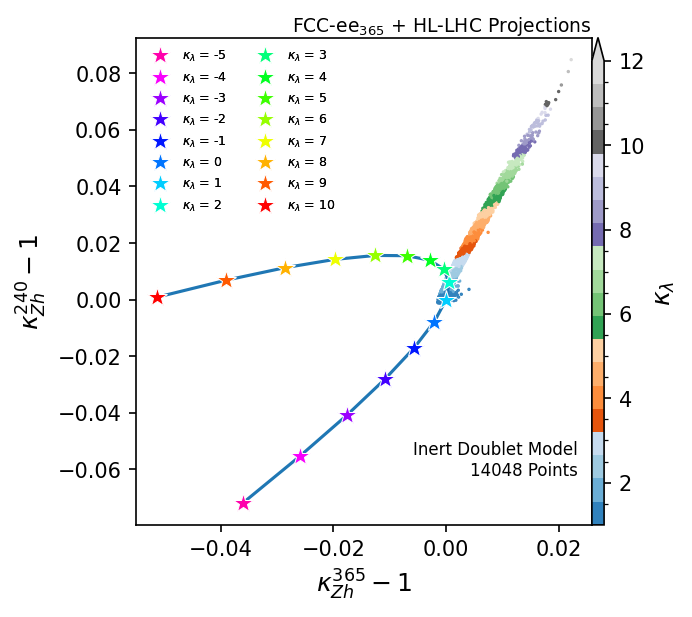

In [6]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        plot_self_consistent_curve='CH',
                        # plot_name_suffix='_with_self_consistent_curve_CH',
                )

Processing data file: data/IDM/allIDMpoints_2025-01-14


(<Figure size 675x600 with 2 Axes>,
 <Axes: xlabel='$\\kappa_{Zh}^{365} - 1$', ylabel='$\\kappa_{Zh}^{240} - 1$'>)

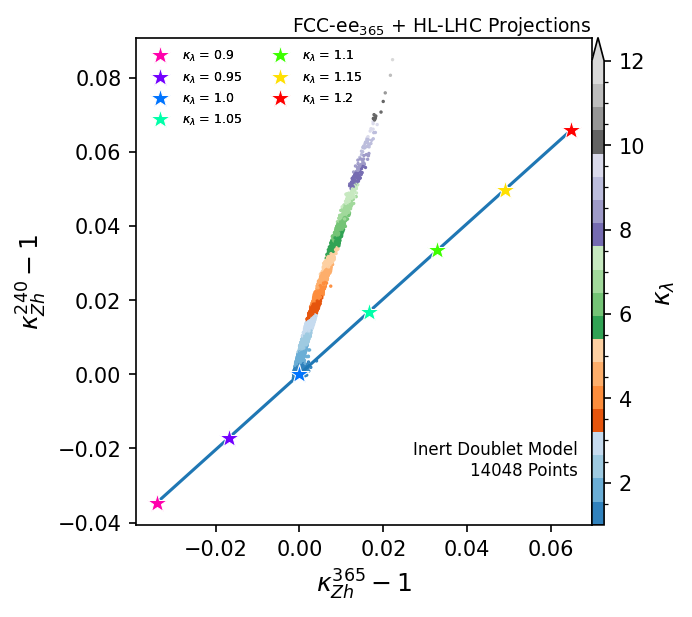

In [7]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
plot_EffZZH_240_vs_365(data_file, plot_dir,
                        plot_self_consistent_curve='CHbox',
                        # plot_name_suffix='_with_self_consistent_curve_CHbox',
                )

Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']


(<Figure size 675x600 with 2 Axes>,
 <Axes: xlabel='$\\kappa_{Zh}^{365} - 1$', ylabel='$\\kappa_{Zh}^{240} - 1$'>)

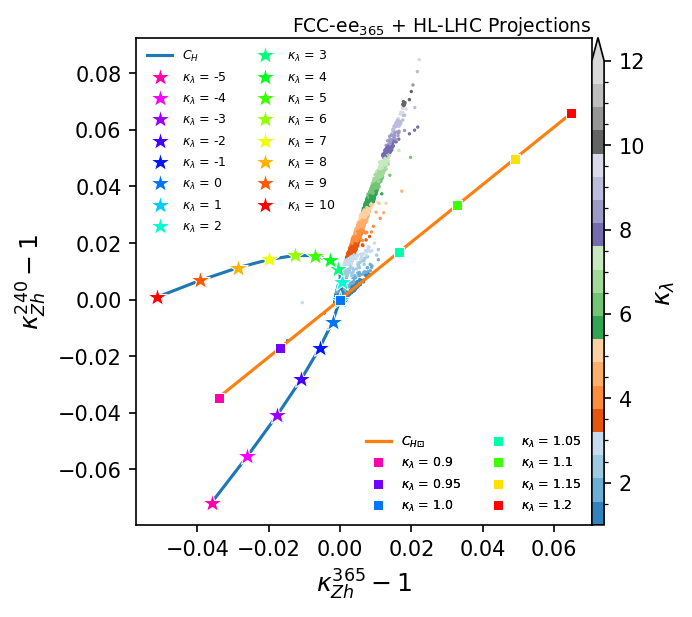

In [8]:
# data_file = "data/IDM/allIDMpoints_2025-01-14"
data_file = ["data/IDM/allIDMpoints_2025-01-14",
             "data/IDM/outlierIDMpoints_2025-01-17",
             "data/IDM/outlierIDMpoints2_2025-01-17",
             "data/IDM/outlierIDMpoints3_2025-01-17",
             "data/IDM/outlierIDMpoints4_2025-01-17",
             ]
plot_dir = "plots/IDM"
plot_EffZZH_240_vs_365(data_file, plot_dir,
                        plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix='_with_self_consistent_curve_CH_CHbox',
                        no_model_text=True
                )

In [9]:
def plot_self_consistent_curve(curves, files, fig, ax, labels, colors_line, markers, markersizes, n_legends=1):
    if not curves is None:
        
        legend_loc = "best"
        colors = mpl.colormaps['hsv']

        if all([isinstance(arg, str) for arg in (curves, files, labels, colors_line, markers, markersizes)]):

            leg_handles = []

            lambdas=[]
            k_ZH_240 = {}
            k_ZH_365 = {}

            file_name = files

            with open(file_name, "r") as self_consistent_results_file:
                lines = self_consistent_results_file.readlines()
                for n, line in enumerate(lines):
                    columns = line.split()

                    if curves=='CH':
                        lmbd = int(columns[0])
                    if curves=='CHbox':
                        lmbd = float(columns[0])

                    lambdas.append(lmbd)
                    if columns[1].startswith("eeZH_FCCee240"):
                        k_ZH_240[lmbd] = np.sqrt(float(columns[2]))
                    elif columns[1].startswith("eeZH_FCCee365"):
                        k_ZH_365[lmbd] = np.sqrt(float(columns[2]))

            # print(lambdas)
            # print(k_ZH_240)
            # print(k_ZH_365)

            lambdas_unique = [lmbd for i, lmbd in enumerate(lambdas) if i%2==0 ]
            
            color = list(colors(np.linspace(0.001, 0.9, len(lambdas_unique))[::-1]))

            ax.plot([(k_ZH_365[lmbd]-1) for lmbd in lambdas_unique],
                    [(k_ZH_240[lmbd]-1) for lmbd in lambdas_unique],
            )

            for i, lmbd in enumerate(lambdas_unique):
                ax.plot((k_ZH_365[lmbd]-1), (k_ZH_240[lmbd]-1), marker="*", ls="none", c=color[i], markersize=10, markeredgecolor='white', markeredgewidth=0.5)

                point_label = rf"$\kappa_\lambda$ = {lmbd}"
                leg_handles.append(Line2D([0], [0], color="k", ls="none", marker="*", c=color[i], markersize=10, markeredgecolor='white', markeredgewidth=0.5, label=point_label))

            hsLegend = ax.legend(
                        handles=leg_handles,
                        loc=legend_loc,
                        frameon=False,
                        prop={'size': 6},
                        ncol=2,
                    )
            ax.add_artist(hsLegend)


        elif all(isinstance(arg, list) for arg in (curves, files, labels, colors_line, markers, markersizes)) \
            and all( len(curves) == len(arg) for arg in (files, labels, colors_line, markers, markersizes)):
            # and all( isinstance(item, str) for arg in (curves, files, labels, colors_line, markers, markersizes) for item in arg) \

            # if curves==["CH", "CHbox"]:

            lambdas = {}
            k_ZH_240 = {}
            k_ZH_365 = {}
            
            for wc_index, (WC, file_name, label_line, color_line, marker, markersize) in enumerate(zip(curves, files, labels, colors_line, markers, markersizes)):

                if wc_index == 0:
                    leg_handles = []
                    leg_handles_lines = []
                
                lambdas[WC] = []
                k_ZH_240[WC] = {}
                k_ZH_365[WC] = {}

                if WC=='CH':
                    legend_loc='upper left'
                elif WC=='CHbox':
                    legend_loc='lower right'

                legend_loc_lines='lower right'


                with open(file_name, "r") as self_consistent_results_file:
                    lines = self_consistent_results_file.readlines()
                    for n, line in enumerate(lines):
                        columns = line.split()

                        if WC=='CH':
                            lmbd = int(columns[0])
                        if WC=='CHbox':
                            lmbd = float(columns[0])

                        lambdas[WC].append(lmbd)
                        if columns[1].startswith("eeZH_FCCee240"):
                            k_ZH_240[WC][lmbd] = np.sqrt(float(columns[2]))
                        elif columns[1].startswith("eeZH_FCCee365"):
                            k_ZH_365[WC][lmbd] = np.sqrt(float(columns[2]))

                # print(lambdas[WC])
                # print(k_ZH_240[WC])
                # print(k_ZH_365[WC])

                lambdas_unique = [lmbd for i, lmbd in enumerate(lambdas[WC]) if i%2==0 ]
                
                color = list(colors(np.linspace(0.001, 0.9, len(lambdas_unique))[::-1]))

                ax.plot([(k_ZH_365[WC][lmbd]-1) for lmbd in lambdas_unique],
                        [(k_ZH_240[WC][lmbd]-1) for lmbd in lambdas_unique],
                        color=color_line,
                )
                leg_handles_lines.append(Line2D([0], [0], color="k", ls="-", c=color_line, label=label_line))
                # print(leg_handles_lines)

                for i, lmbd in enumerate(lambdas_unique):
                    ax.plot((k_ZH_365[WC][lmbd]-1), (k_ZH_240[WC][lmbd]-1), marker=marker, ls="none", c=color[i], markersize=markersize, markeredgecolor='white', markeredgewidth=0.5)

                    point_label = rf"$\kappa_\lambda$ = {lmbd}"
                    if not (n_legends == 1 and wc_index != (len(curves) - 1)):
                        leg_handles.append(Line2D([0], [0], color="k", ls="none", marker=marker, c=color[i], markersize=markersize, markeredgecolor='white', markeredgewidth=0.5, label=point_label))


                if not (n_legends == 1 and wc_index != (len(curves) - 1)):
                    hsLegend = ax.legend(
                        handles=leg_handles,
                        loc=legend_loc,
                        frameon=False,
                        prop={'size': 6},
                        ncol=2,
                    )
                    ax.add_artist(hsLegend)

                    hsLegend_lines = ax.legend(
                        handles=leg_handles_lines,
                        loc=legend_loc_lines,
                        frameon=False,
                        prop={'size': 5},
                        ncol=1,
                    )
                    ax.add_artist(hsLegend_lines)

        else:
            raise ValueError("Please specify valid curves / files!")
        
    return fig, ax

Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']


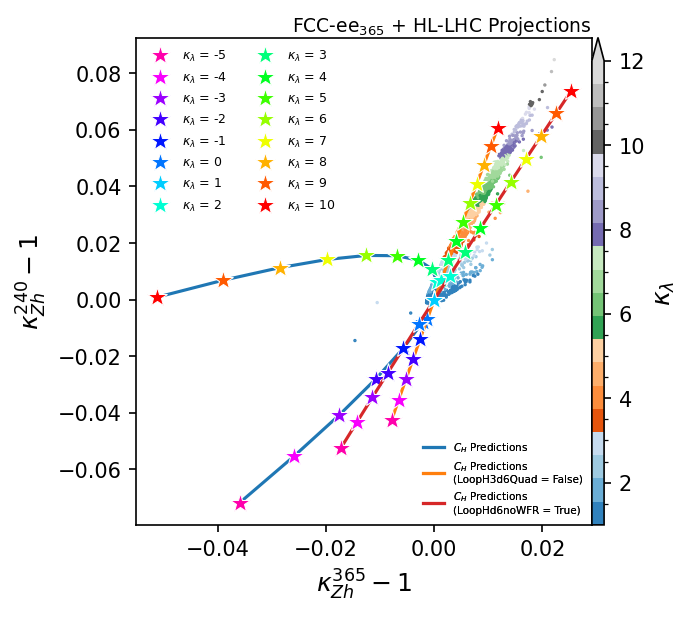

In [10]:
data_file = ["data/IDM/allIDMpoints_2025-01-14",
             "data/IDM/outlierIDMpoints_2025-01-17",
             "data/IDM/outlierIDMpoints2_2025-01-17",
             "data/IDM/outlierIDMpoints3_2025-01-17",
             "data/IDM/outlierIDMpoints4_2025-01-17",
             ]
plot_dir = "plots/IDM"
plot_name = "IDM_results_k_ZH_240_vs_365"
plot_name_suffix = "_with_self_consistent_curves"
fig, ax = plot_EffZZH_240_vs_365(
    data_file, 
    plot_dir, 
    # plot_self_consistent_curve=['CH', 'CHbox'],
    # plot_name_suffix='_with_self_consistent_curve_CH',
    no_model_text=True
)

# plot_self_consistent_curve='CH',
# plot_name_suffix='_with_self_consistent_curve_CH',

curves = [
    "CH",
    "CH",
    "CH",
]

file_dir = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee"
files = [
    f"{file_dir}/large_kappa_lambda_fits/comparison_plots/k_ZH_240_365_predictions.txt",
    f"{file_dir}/large_kappa_lambda_fits_noLoopH3d6Quad/comparison_plots/k_ZH_240_365_predictions.txt",
    # f"{file_dir}/large_kappa_lambda_fits_noSubleading/comparison_plots/k_ZH_240_365_predictions.txt",
    f"{file_dir}/large_kappa_lambda_fits_LoopHd6noWFR/comparison_plots/k_ZH_240_365_predictions.txt",
]

labels = [
    # r'$C_{H}$ Predictions'+' \n(LoopH3d6Quad = True)',
    r'$C_{H}$ Predictions'+'',
    r'$C_{H}$ Predictions'+' \n(LoopH3d6Quad = False)',
    # r'$C_{H}$ Predictions'+' \n(LoopHd6NoSubleading = True)',
    r'$C_{H}$ Predictions'+' \n(LoopHd6noWFR = True)',
    # r'$C_{H\boxdot}$',
]

colors = [
    "tab:blue",
    "tab:orange",
    "tab:red",
]

markers = [
    "*",
    "*",
    "*",
]

markersizes = [
    10,
    10,
    10,
]

fig, ax = plot_self_consistent_curve(
    curves, 
    files, 
    fig, 
    ax, 
    labels, 
    colors, 
    markers, 
    markersizes, 
    n_legends=1
)

plt.show()
fig.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+".pdf")


Processing data file: data/IDM/allIDMpoints_2025-01-14
Number of points satisfying the 5% SM constraint on the single higgs couplings: 14014 / 14048


(<Figure size 675x600 with 2 Axes>,
 <Axes: xlabel='$\\kappa_{Zh}^{365} - 1$', ylabel='$\\kappa_{Zh}^{240} - 1$'>)

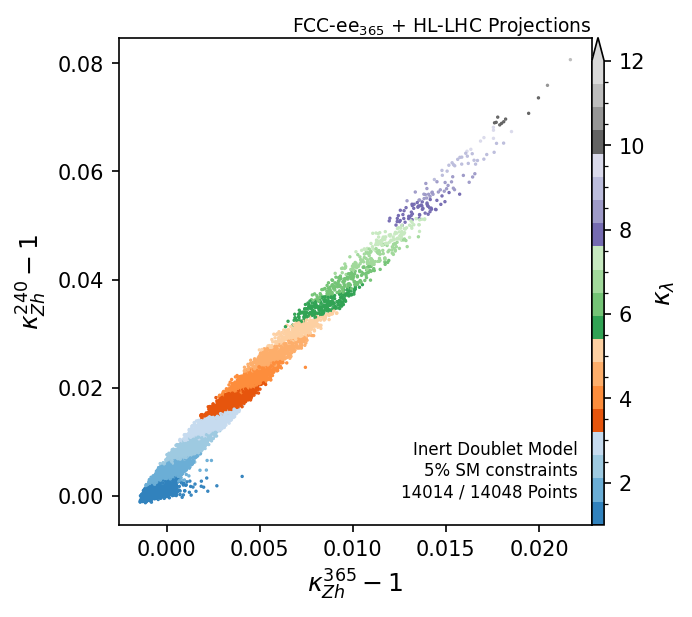

In [11]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
BR_constraints = 0.05
plot_EffZZH_240_vs_365(data_file, plot_dir,
                       BR_constraints=BR_constraints
                )

Processing data file: data/IDM/allIDMpoints_2025-01-14
Number of points satisfying the 5% SM constraint on the single higgs couplings: 14014 / 14048


(<Figure size 675x600 with 2 Axes>,
 <Axes: xlabel='$\\kappa_{Zh}^{365} - 1$', ylabel='$\\kappa_{Zh}^{240} - 1$'>)

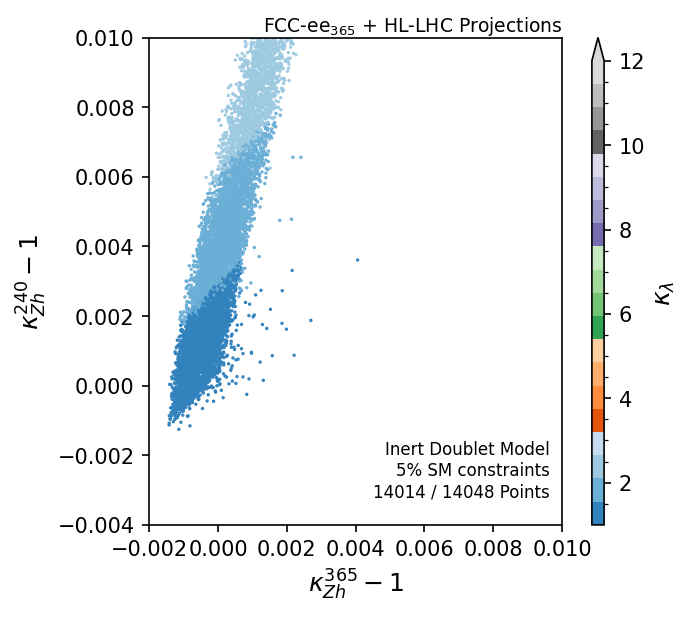

In [12]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
BR_constraints = 0.05
plot_EffZZH_240_vs_365(data_file, plot_dir,
                       BR_constraints=BR_constraints,
                       zoom=True,
                       zoom_range_x=(-0.002, 0.01), 
                       zoom_range_y=(-0.004, 0.01),
                )

Processing data file: data/IDM/allIDMpoints_2025-01-14
Number of points satisfying the 1% SM constraint on the single higgs couplings: 533 / 14048


(<Figure size 675x600 with 2 Axes>,
 <Axes: xlabel='$\\kappa_{Zh}^{365} - 1$', ylabel='$\\kappa_{Zh}^{240} - 1$'>)

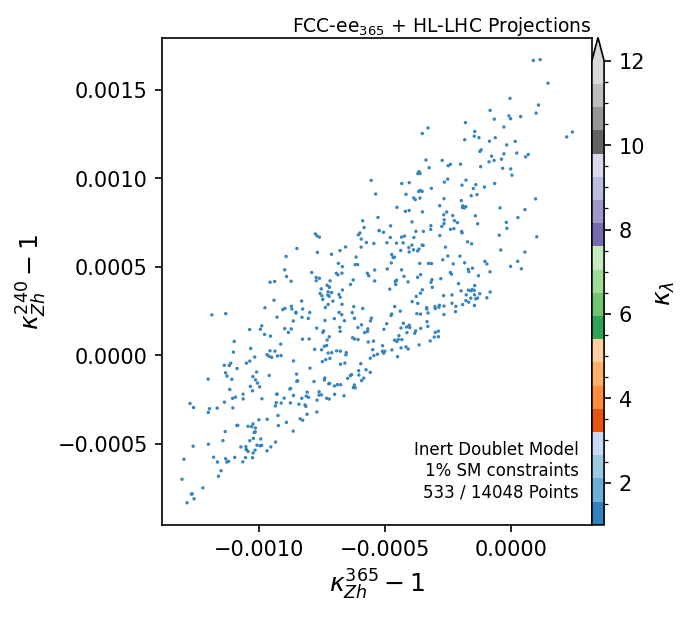

In [13]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
BR_constraints = 0.01
plot_EffZZH_240_vs_365(data_file, plot_dir,
                       BR_constraints=BR_constraints
                )

### Finding Outlier Points 

In [14]:
full=True
BR_constraints=0.05
data_file="data/IDM/allIDMpoints_2025-01-14"
df = pd.read_csv(data_file + ".csv")

df = df.replace("", np.nan)
df = df.dropna()
old_df_indices = df.index.to_numpy()
df = df.reset_index(drop=True)

kappas, EWPOs, model_pars = read_IDM_file(df)

def print_to_file(message, file):
    print(message)
    print(message, file=file)

def find_benchmark(df,
                   kappas,
                   EWPOs,
                   old_df_indices,
                   BP_Names,
                   BP_output_file,
                   max_errors_365,
                   max_errors_240,
                   delta_kappas_z_365,
                   delta_kappas_z_240,
                   BR_constraints=None,
                   ):

    n_pts = df.shape[0]

    if not BR_constraints is None:
        satisfy_BR_constraint = [True for i in range(n_pts)]
        for i in range(n_pts):
            for coup in ['uu', 'dd', 'cc', 'ss', 'tt', 'bb', 'ee', 'mumu', 'tautau', 'WW', 'ZZ', 'Zgam', 'gamgam']:
                if np.abs(kappas[coup][i] - 1.) > BR_constraints:
                    satisfy_BR_constraint[i] = False

        for coup in kappas.keys():
            kappas[coup] = np.array(kappas[coup][satisfy_BR_constraint])
        
        for ewpo in EWPOs.keys():
            EWPOs[ewpo] = np.array(EWPOs[ewpo][satisfy_BR_constraint])

        for par in model_pars.keys():
            model_pars[par] = np.array(model_pars[par][satisfy_BR_constraint])

        old_df_indices = old_df_indices[satisfy_BR_constraint]

    delta_kZ_240_365 = np.full((n_pts,), np.nan)
        

    if not len(delta_kappas_z_365) == len(delta_kappas_z_240):
        raise ValueError("delta_kappas_z_365 and delta_kappas_z_240 have different lengths!")

    bp_indices = [None for i in range(len(delta_kappas_z_365))]
    bp_kappas = [None for i in range(len(delta_kappas_z_365))]
    bp_EWPOs = [None for i in range(len(delta_kappas_z_365))]
    bp_model_pars = [None for i in range(len(delta_kappas_z_365))]

    for ind, (kZ_365, kZ_240) in enumerate(zip(kappas['ZZ_365'], kappas['ZZ_240'])):
        for BP, (delta_kappa_z_365, delta_kappa_z_240, max_error_365, max_error_240) in enumerate(zip(delta_kappas_z_365, delta_kappas_z_240, max_errors_365, max_errors_240)):
            if abs((kZ_365-1) - delta_kappa_z_365) < max_error_365 and abs((kZ_240-1) - delta_kappa_z_240) < max_error_240:
                bp_indices[BP] = ind


    if any(bp_index is None for bp_index in bp_indices):
        missing_BPs = [i for i, bp_index in enumerate(bp_indices) if bp_index is None]
        raise ValueError(f"The following BPs were not found: {missing_BPs}")


    for BP, bp_index in enumerate(bp_indices):

        print_to_file(f"\nelif BP == \"{BP_Names[BP]}\":", file=BP_output_file)

        # bfp_chisq = chisq[bp_index]
        bp_kappas[BP] = {coup:kps[bp_index] for (coup, kps) in kappas.items()}
        bp_EWPOs[BP] = {obs_name:obs_value[bp_index] for (obs_name, obs_value) in EWPOs.items()}
        bp_model_pars[BP] = {par_name:par_value[bp_index] for (par_name, par_value) in model_pars.items()}

        for coup, kaps in bp_kappas[BP].items():
            print_to_file(f"    kappas['{coup}'] = {kaps}", file=BP_output_file)

        print_to_file(f"    # abs(kappas['ZZ_365'] - kappas['ZZ_240'])/(kappas['ZZ_240'] - 1) = {np.abs((bp_kappas[BP]['ZZ_365'] - bp_kappas[BP]['ZZ_240'])/(bp_kappas[BP]['ZZ_240'] - 1))}", file=BP_output_file)
        print_to_file(f"    # abs(kappas['ZZ_365'] - kappas['ZZ_240']) = {np.abs(bp_kappas[BP]['ZZ_365'] - bp_kappas[BP]['ZZ_240'])}", file=BP_output_file)

        for obs_name, obs_value in bp_EWPOs[BP].items():
            print_to_file(f"    {obs_name} = {obs_value}", file=BP_output_file)

        for par_name, par_value in bp_model_pars[BP].items():
            print_to_file(f"    # {par_name} = {par_value}", file=BP_output_file)

        print_to_file(f"    # Best scan point row: {old_df_indices[bp_index]+2} out of {old_df_indices[-1]+2}", file=BP_output_file)

        if delta_kZ_240_365[bp_index] == np.inf: 
            raise ValueError("Could not find point satisfying the constraints!")
        
    return bp_kappas, bp_EWPOs, bp_model_pars, bp_indices


output_dir = "./scan_output/IDM_scan_output"
subprocess.run(["mkdir", "-p", output_dir])

BP_filename = f"{output_dir}/Benchmark_Points_outliers.txt"
BR_constraint=0.05
with open(BP_filename, "w") as BP_output_file:

    max_errors_365 = [1e-3, 1e-3, 1e-3, 1e-3, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 4e-4, 4e-4, 4e-4]
    max_errors_240 = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 2e-3, 2e-3, 2e-3]
    delta_kappas_z_365 = [0.0075, 0.004, -0.0024, 0.001, 0.0001, 0.0024, 0.0017, 0.0046, 0.0040, 0.0068, 0.0063, 0.0092, 0.0086, 0.0116, 0.011, 0.0140, 0.0140, 0.0165, 0.0164, 0.0195, 0.022]
    delta_kappas_z_240 = [0.023, 0.004, -0.0020, -0.0005, 0.008, 0.009, 0.016, 0.017, 0.0225, 0.025, 0.0325, 0.033, 0.040, 0.041, 0.049, 0.051, 0.058, 0.060, 0.066, 0.071, 0.08]



    BP_Names = ["BPO_0", "BPO_1"]
    BP_Names = BP_Names + [f"BPB_{i}" for i in range(len(delta_kappas_z_240)-2)]
    BP_Names_legend = ["BPO 0", "BPO 1"]
    BP_Names_legend = BP_Names_legend + [f"BPB {i}" for i in range(len(delta_kappas_z_240)-2)]

    bp_kappas , bp_EWPOs, bp_model_pars, bp_indices = find_benchmark(df=df,
                               EWPOs=EWPOs,
                               kappas=kappas,
                               old_df_indices=old_df_indices,
                               BP_Names=BP_Names,
                               BP_output_file=BP_output_file,
                               max_errors_365=max_errors_365,
                               max_errors_240=max_errors_240,
                               delta_kappas_z_365=delta_kappas_z_365,
                               delta_kappas_z_240=delta_kappas_z_240,
                               BR_constraints=BR_constraints,
                              )


elif BP == "BPO_0":
    kappas['uu'] = 0.9818547810617284
    kappas['dd'] = 0.9818547810617284
    kappas['ss'] = 0.9818547810617284
    kappas['cc'] = 0.9818547810617284
    kappas['bb'] = 0.9818547810617284
    kappas['tt'] = 0.9818547810617284
    kappas['ee'] = 0.9818547810617284
    kappas['mumu'] = 0.9818547810617284
    kappas['tautau'] = 0.9818547810617284
    kappas['ZZ_0'] = 1.007141704579298
    kappas['ZZ_240'] = 1.0237693288776533
    kappas['ZZ_365'] = 1.0074536101415776
    kappas['ZZ_500'] = 1.0026988104523176
    kappas['ZZ_550'] = 1.0021232678597285
    kappas['ZZ'] = 0.9899392240917029
    kappas['WW'] = 0.9899392240917029
    kappas['lam'] = 4.038636858901748
    kappas['gamgam'] = 0.9514322699531608
    kappas['Zgam'] = 0.9820015140523058
    kappas['ZZ_0_with_WFR'] = 0.9953498248226368
    kappas['ZZ_240_with_WFR'] = 1.0119172507528293
    kappas['ZZ_365_with_WFR'] = 0.9956631382646509
    kappas['ZZ_500_with_WFR'] = 0.990876120168658
    kappas['ZZ_550_with_WFR

In [15]:
print("std::vector<float> base_KappaLambdas = {")
for BP, BP_name in zip(bp_kappas, BP_Names):
    print(f"        {BP['lam']}, // {BP_name}")
print("    };")

std::vector<float> base_KappaLambdas = {
        4.038636858901748, // BPO_0
        1.2385642568656816, // BPO_1
        1.1209067864736006, // BPB_0
        1.1119460475058272, // BPB_1
        2.3867362274064843, // BPB_2
        2.296737570137434, // BPB_3
        3.3446699219962595, // BPB_4
        3.3186760761499228, // BPB_5
        4.332584967850238, // BPB_6
        4.324280052220163, // BPB_7
        5.390968560325193, // BPB_8
        5.289906405452073, // BPB_9
        6.370034303736775, // BPB_10
        6.270579956517072, // BPB_11
        7.515862276796717, // BPB_12
        7.466008740779396, // BPB_13
        8.611459058586306, // BPB_14
        8.459762817722257, // BPB_15
        9.319513844125106, // BPB_16
        9.888810967739037, // BPB_17
        11.2535829810942, // BPB_18
    };


### Plotting the obtained points

Processing data file: data/IDM/allIDMpoints_2025-01-14
Number of points satisfying the 5% SM constraint on the single higgs couplings: 14014 / 14048


(<Figure size 675x600 with 2 Axes>,
 <Axes: xlabel='$\\kappa_{Zh}^{365} - 1$', ylabel='$\\kappa_{Zh}^{240} - 1$'>)

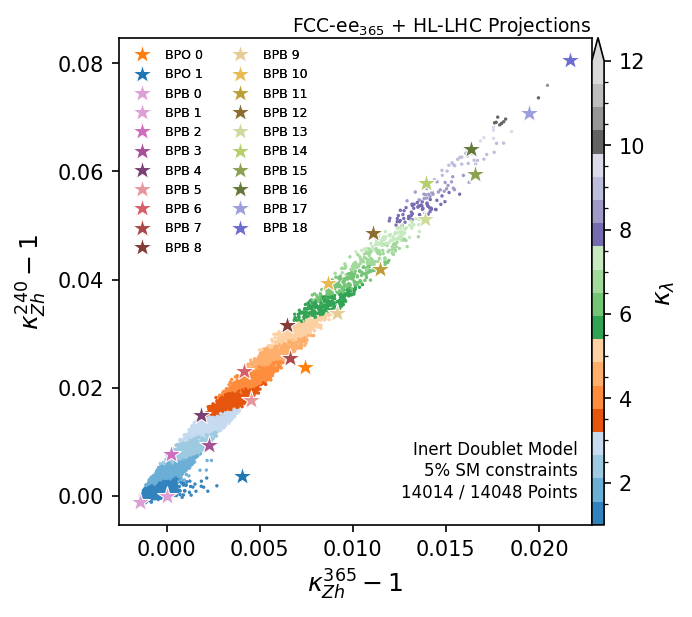

In [16]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
BR_constraints = 0.05
plot_points = [(BP["ZZ_365"]-1, BP["ZZ_240"]-1, label) for BP, label in zip(bp_kappas, BP_Names_legend)]

plot_EffZZH_240_vs_365(data_file, plot_dir,
                       BR_constraints=BR_constraints,
                       plot_points=plot_points,
                )

## Plotting the obtained points including the Higgs self-energy contributions to $\sigma_{Zh}$

In [17]:
# Johannes' formula
sqrt = np.sqrt
Mh = 125.1
vev = 246.21965
@np.vectorize
def ZZh_hextleg(kala):
    dZh = -(Mh**2*(-9 + 2*np.sqrt(3)*np.pi))/(32*np.pi**2*vev**2)
    return (kala**2-1)*dZh

Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']


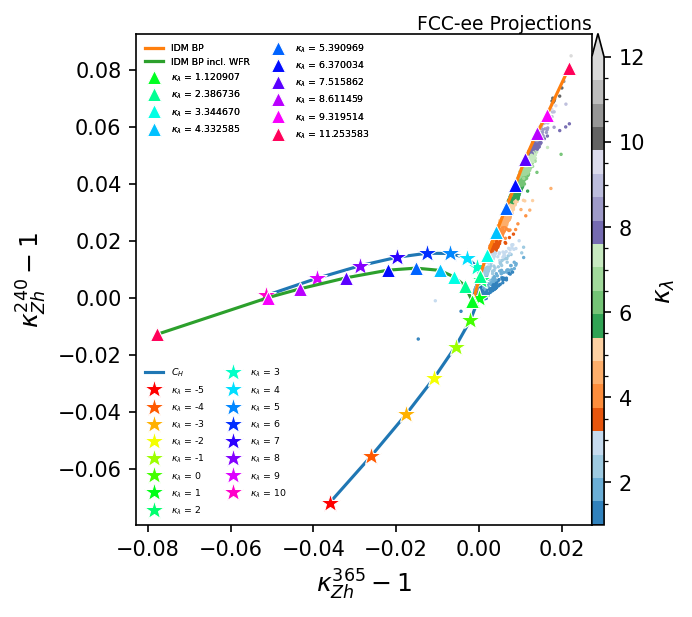

In [18]:
plot_points = [(BP["ZZ_365"]-1, BP["ZZ_240"]-1, BP["lam"], label) for BP, label in zip(bp_kappas, BP_Names_legend)]

plot_points_with_WFR = [
    (sqrt( (BP["ZZ_365"])**2 + ZZh_hextleg( BP["lam"] ) ) - 1,
     sqrt( (BP["ZZ_240"])**2 + ZZh_hextleg( BP["lam"] ) ) - 1,
     BP["lam"],
     label, ) for BP, label in zip(bp_kappas, BP_Names_legend)
]

# Plot only the even-numbered BPBs
plot_points = plot_points[2::2]
plot_points_with_WFR = plot_points_with_WFR[2::2]


data_file = ["data/IDM/allIDMpoints_2025-01-14",
             "data/IDM/outlierIDMpoints_2025-01-17",
             "data/IDM/outlierIDMpoints2_2025-01-17",
             "data/IDM/outlierIDMpoints3_2025-01-17",
             "data/IDM/outlierIDMpoints4_2025-01-17",
             ]

plot_dir = "plots/IDM"
plot_name = "IDM_results_k_ZH_240_vs_365"
plot_name_suffix = "_with_self_consistent_curves_with_WFR"

fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections"
                )

curves = [
    "CH", 
    # "CHbox", 
    "IDM",
    "IDM_SMEFT",
]
file_names = [
    "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits/comparison_plots/k_ZH_240_365_predictions.txt",
    # "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits_CHbox/comparison_plots/k_ZH_240_365_predictions.txt",
    None,
    None,
]
data_sets = [
    None,
    plot_points,
    plot_points_with_WFR,
]
legend_locs = [
    'lower left',
    None,
    'upper left',
]
legend_fontsizes = [
    4.5,
    4.5,
    4.5,
]
legend_cols = [
    2,
    2,
    2,
]
markers = [
    "*", 
    "^",
    "^",
]
color_lines = [
    "tab:blue", 
    "tab:orange",
    "tab:green",
]
label_lines = [
    r'$C_{H}$', 
    # r'$C_{H\boxdot}$',
    r'IDM BP',
    r'IDM BP incl. WFR',
]
markersizes = [
    10, 
    7,
    7,
]


def plot_curve (curves, file_names, data_sets, legend_locs, legend_cols, markers, color_lines, label_lines, markersizes, legend_point_label=None):

    colors = mpl.colormaps['hsv']
    norm = Normalize(vmin=-5.0, vmax=12.)

    lambdas = {}
    k_ZH_240 = {}
    k_ZH_365 = {}

    leg_handles = []
    for index, (curve, file_name, data_set, legend_loc, legend_col, legend_fontsize, marker, color_line, label_line, markersize) in enumerate(zip(curves, file_names, data_sets, legend_locs, legend_cols, legend_fontsizes, markers, color_lines, label_lines, markersizes)):

        lambdas[curve] = []
        k_ZH_240[curve] = {}
        k_ZH_365[curve] = {}

        if file_name is not None and data_set is None:

            with open(file_name, "r") as self_consistent_results_file:
                lines = self_consistent_results_file.readlines()
                for n, line in enumerate(lines):
                    columns = line.split()

                    if curve=='CH':
                        lmbd = int(columns[0])
                    elif curve=='CHbox':
                        lmbd = float(columns[0])
                    else:
                        lmbd = float(columns[0])

                    lambdas[curve].append(lmbd)
                    if columns[1].startswith("eeZH_FCCee240"):
                        k_ZH_240[curve][lmbd] = np.sqrt(float(columns[2]))
                    elif columns[1].startswith("eeZH_FCCee365"):
                        k_ZH_365[curve][lmbd] = np.sqrt(float(columns[2]))

            lambdas_unique = [lmbd for i, lmbd in enumerate(lambdas[curve]) if i%2==0 ]

        elif file_name is None and data_set is not None:
            for bp in data_set:
                lmbd = bp[2]
                lambdas[curve].append(lmbd)
                k_ZH_365[curve][lmbd] = bp[0] + 1
                k_ZH_240[curve][lmbd] = bp[1] + 1
            lambdas_unique = lambdas[curve]
        else:
            raise ValueError("Please specify valid curves / files!")

        # print(lambdas[curve])
        # print(k_ZH_240[curve])
        # print(k_ZH_365[curve])
        
        # color = list(colors(np.linspace(0.001, 0.9, len(lambdas_unique))[::-1]))
        color = list(colors(norm(np.array(lambdas_unique))))

        ax.plot([(k_ZH_365[curve][lmbd]-1) for lmbd in lambdas_unique],
                [(k_ZH_240[curve][lmbd]-1) for lmbd in lambdas_unique],
                color=color_line,
        )
        if legend_loc is not None:
            leg_handles.append(Line2D([0], [0], color="k", ls="-", c=color_line, label=label_line))
        else:
            leg_handles.insert(index, Line2D([0], [0], color="k", ls="-", c=color_line, label=label_line))
            # leg_handles = [Line2D([0], [0], color="k", ls="-", c=color_line, label=label_line)] + leg_handles

        for i, lmbd in enumerate(lambdas_unique):
            ax.plot((k_ZH_365[curve][lmbd]-1), (k_ZH_240[curve][lmbd]-1), marker=marker, ls="none", c=color[i], markersize=markersize, markeredgecolor='white', markeredgewidth=0.5)

            if legend_point_label is None:
                kala = r"$\kappa_\lambda$"
            else:
                kala = legend_point_label
            if isinstance(lmbd, int):
                point_label = rf"{kala} = {lmbd}"
            else:
                point_label = rf"{kala} = {lmbd:.6f}"
            
            if legend_loc is not None:
                leg_handles.append(Line2D([0], [0], color="k", ls="none", marker=marker, c=color[i], markersize=markersize, markeredgecolor='white', markeredgewidth=0.5, label=point_label))

        if legend_loc is not None:
            hsLegend = ax.legend(
                handles=leg_handles,
                loc=legend_loc,
                frameon=False,
                prop={'size': legend_fontsize},
                ncol=legend_col,
            )
            ax.add_artist(hsLegend)

            leg_handles = []

plot_curve(curves, file_names, data_sets, legend_locs, legend_cols, markers, color_lines, label_lines, markersizes)
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+".pdf")

plt.show()




Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']


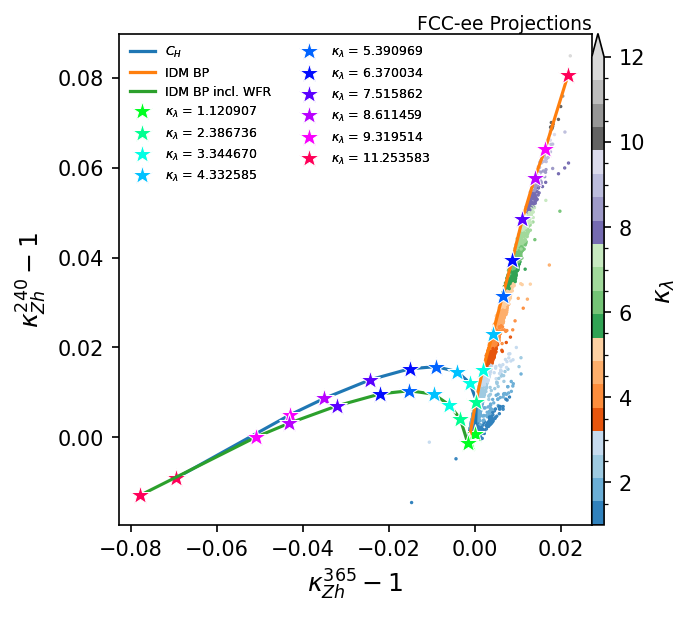

In [19]:
fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir, 
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections",
                )

legend_locs = [
    None,
    None,
    'upper left',
]
legend_fontsizes = [
    6.0,
    6.0,
    6.0,
]
markers = [
    "*", 
    "*", 
    "*", 
]
markersizes = [
    10, 
    10, 
    10, 
]
curves_matching_lambdas = [
    "CH_matching_lambdas", 
    # "CHbox", 
    "IDM",
    "IDM_SMEFT",
]
file_names_matching_lambdas = [
    "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits/comparison_plots/k_ZH_240_365_predictions_general_lambdas.txt",
    # "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits_CHbox/comparison_plots/k_ZH_240_365_predictions_general_lambdas.txt",
    None,
    None,
]
plot_curve(curves_matching_lambdas, file_names_matching_lambdas, data_sets, legend_locs, legend_cols, markers, color_lines, label_lines, markersizes)
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"_matching_lambdas.pdf")

In [20]:
input_file = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/generate_HEPfit_predictions/results/k_ZH_240_365_central_value_results.txt"

k_ZH_240 = []
k_ZH_365 = []
lmbd = []
CH = []
CHBox = []

with open(input_file, "r") as f:
    for i, line in enumerate(f):
        if i == 0:
            continue  # skip header if there is one
        columns = line.strip().split(",")
        if len(columns) < 5:
            continue  # skip malformed lines
        k_ZH_240.append(float(columns[0]))
        k_ZH_365.append(float(columns[1]))
        lmbd.append(float(columns[2]))
        CH.append(float(columns[3]))
        CHBox.append(float(columns[4]))

print(len(CH))


1620


x = [-0.00430896  0.00364763 -0.00161574 -0.00014061 -0.00340644 -0.00102279
 -0.00599543 -0.00319269 -0.00953204 -0.00700236 -0.01522729 -0.0116605
 -0.02196337 -0.01811418 -0.03207735 -0.02857264 -0.04320642 -0.03834242
 -0.05088192 -0.05643476 -0.07778185]
y = [ 1.21963759e-02  3.19827305e-03 -1.27503392e-03 -1.58315528e-04
  4.17895232e-03  6.23903564e-03  7.25964481e-03  1.01397460e-02
  9.60539890e-03  1.20829284e-02  1.03774628e-02  1.34654144e-02
  9.67417293e-03  1.31769809e-02  6.99820201e-03  1.03446545e-02
  3.12446624e-03  7.00034758e-03  5.59962747e-05 -1.25983104e-03
 -1.28737288e-02]
(21, 21)
[ 3.93296929         nan         nan         nan  2.34298014  2.2884746
  3.34748093  3.36782185  4.38774401  4.38670286  5.52107593  5.45124494
  6.56538536  6.52467557  7.82932103  7.8250889   9.03580112  8.89926412
  9.7865232  10.48394621 11.96738138]
plot_points_interpolation = ((-0.0016157410088161184, -0.0012750339158719148, nan, 'BPB 0'), (-0.0034064425487808636, 0.00417895

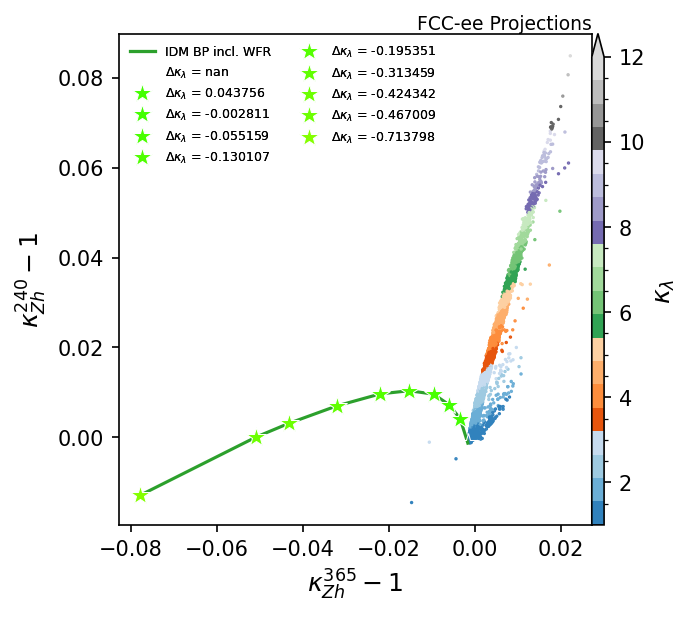

In [21]:
from scipy.interpolate import LinearNDInterpolator
import numpy as np

interp = LinearNDInterpolator(list(zip(k_ZH_365, k_ZH_240)), lmbd)

x = np.array([sqrt( (BP["ZZ_365"])**2 + ZZh_hextleg( BP["lam"] ) ) - 1 for BP in bp_kappas])
y = np.array([sqrt( (BP["ZZ_240"])**2 + ZZh_hextleg( BP["lam"] ) ) - 1 for BP in bp_kappas])
print(f"x = {x}")
print(f"y = {y}")
lmbd_BPs = np.array([BP["lam"] for BP in bp_kappas])

X, Y = np.meshgrid(np.array(x)+1, np.array(y)+1)  # 2D grid for interpolation
Z = interp(X, Y)
print(Z.shape)
# print(Z)
Z = np.array([Z[i,i] for i in range(Z.shape[0])])


# print(X)
# print(Y)
print(Z)

plot_points_interpolation = tuple(zip(x, y, lmbd_BPs-Z, BP_Names_legend))
plot_points_interpolation = plot_points_interpolation[2::2]
print(f"plot_points_interpolation = {plot_points_interpolation}")

fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections",
                )
data_sets = [
    plot_points_interpolation,
]

legend_locs = [
    'upper left',
]
legend_fontsizes = [
    6.0,
]
markers = [
    "*", 
]
markersizes = [
    10, 
]
curves_matching_lambdas = [
    "IDM_smeft"
]
file_names_matching_lambdas = [
    None,
]
color_lines = [
    "tab:green",
]
label_lines = [
    r'IDM BP incl. WFR',
]
legend_cols = [
    2,
]
legend_fontsizes = [
    6,
]
legend_point_label = r"$\Delta \kappa_{\lambda}$"
plot_curve(curves_matching_lambdas, file_names_matching_lambdas, data_sets, legend_locs, legend_cols, markers, color_lines, label_lines, markersizes, legend_point_label=legend_point_label)
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"_matching_lambdas_dkala_interp.pdf")


In [22]:
def analytical_formula(mu_240, mu_365):
    dmu = mu_365 - mu_240

    LambdaNP2 = 1000.**2

    C1_240 = 0.017
    C1_365 = 0.0057
    dC = C1_365 - C1_240

    D1_240 = +121263./LambdaNP2
    D1_365 = +121243./LambdaNP2
    dD = D1_365 - D1_240

    M_PI = 3.14159265358979323846
    GF = 1.1663787e-5
    mHl = 125.1

    dZH = -(9.0/16.0)*( GF*mHl*mHl/sqrt(2.0)/M_PI/M_PI )*( 2.0*M_PI/3.0/sqrt(3.0) - 1.0 )

    dZH1 = dZH / (1.0 - dZH)
    dZH2 = dZH * (1 + 3.0 * dZH) / (1.0 - dZH) / (1.0 - dZH)

    a = dZH2
    b = C1_365 + 2*dZH1 - D1_365*dC/dD 
    c = 1 + D1_365*dmu/dD - mu_365

    dlmbd = (-b-sqrt(b**2 - 4*a*c))/(2*a)
    lmbd = 1 + dlmbd

    CHBox = 1./dD*(dmu - dC*dlmbd)
    CH = -2.1290888208276963*(dlmbd - CHBox/5.498361921343667)

    return CH, CHBox, lmbd

Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']


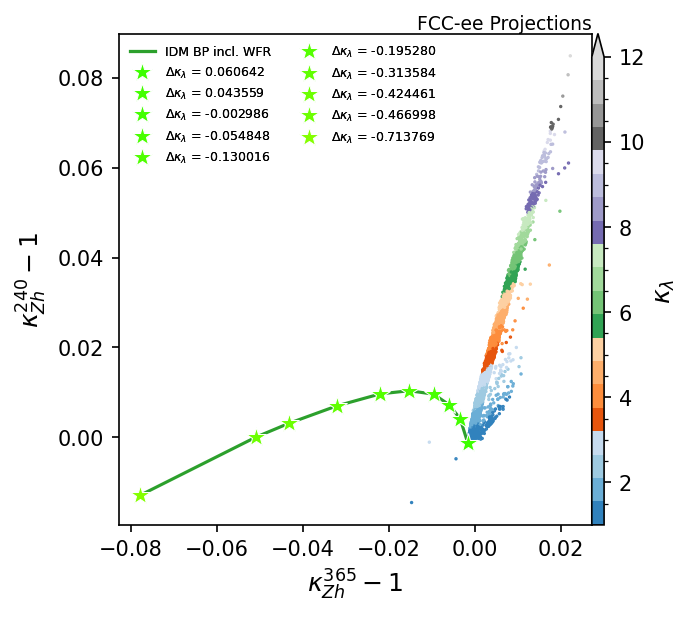

In [23]:
plot_points_analytical_formula = []
for BP, label in zip(bp_kappas, BP_Names_legend):
    k_ZH_365 = sqrt( (BP["ZZ_365"])**2 + ZZh_hextleg( BP["lam"] ) )
    k_ZH_240 = sqrt( (BP["ZZ_240"])**2 + ZZh_hextleg( BP["lam"] ) )
    CH, CHBox, lmbd = analytical_formula(mu_240=k_ZH_240**2, mu_365=k_ZH_365**2)

    plot_points_analytical_formula.append((k_ZH_365-1, k_ZH_240-1, BP["lam"]-lmbd, label))

plot_points_analytical_formula = plot_points_analytical_formula[2::2]
data_sets = [
    plot_points_analytical_formula,
]

fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections",
                )

plot_curve(curves_matching_lambdas, file_names_matching_lambdas, data_sets, legend_locs, legend_cols, markers, color_lines, label_lines, markersizes, legend_point_label=legend_point_label)
# plt.show()
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"_matching_lambdas_dkala_analytical.pdf")

In [24]:
M_PI = 3.14159265358979323846
GF = 1.1663787e-5
mHl = 125.1
sqrt = np.sqrt

def smeft_sigma_Zh(lmbd, sqrt_s):
    mu = 1

    if sqrt_s == 240:
        C1 = 0.017
    elif sqrt_s == 365:
        C1 = 0.0057
    elif sqrt_s == 500:
        C1 = 0.00099
    else:
        raise ValueError("sqrt_s must be 240, 365, or 500 GeV")

    # Expression for the Higgs self-energy diagram
    dZH = -(9.0/16.0)*( GF*mHl*mHl/sqrt(2.0)/M_PI/M_PI )*( 2.0*M_PI/3.0/sqrt(3.0) - 1.0 )
    
    # Resummations
    dZH1 = dZH / (1.0 - dZH)
    dZH2 = dZH * (1 + 3.0 * dZH) / (1.0 - dZH) / (1.0 - dZH)

    # HEPfit flags
    cLHd6 = 1
    cLH3d62 = 1

    deltaG_hhhRatio = lmbd - 1

    mu = mu + cLHd6*(C1 + 2.0*dZH1)*deltaG_hhhRatio

    mu = mu + cLHd6*cLH3d62*dZH2*deltaG_hhhRatio*deltaG_hhhRatio

    return mu

Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']


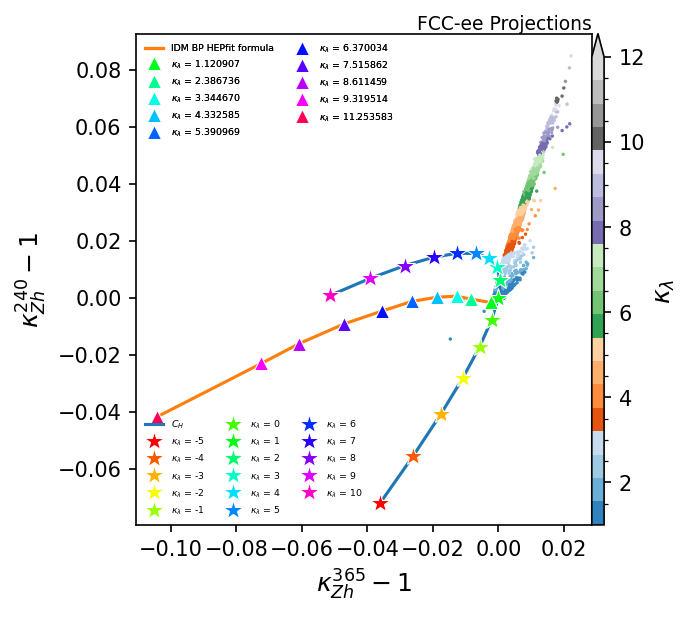

In [25]:
plot_points = [(BP["ZZ_365"]-1, BP["ZZ_240"]-1, BP["lam"], label) for BP, label in zip(bp_kappas, BP_Names_legend)]

plot_points_HEPfit_formula = [
    (sqrt(smeft_sigma_Zh(lmbd=BP["lam"], sqrt_s=365) + 2*(BP["uu"]-1)) - 1,
     sqrt(smeft_sigma_Zh(lmbd=BP["lam"], sqrt_s=240) + 2*(BP["uu"]-1)) - 1,
     BP["lam"],
     label, ) for BP, label in zip(bp_kappas, BP_Names_legend)
]

# Plot only the even-numbered BPBs
plot_points = plot_points[2::2]
plot_points_HEPfit_formula = plot_points_HEPfit_formula[2::2]


data_file = ["data/IDM/allIDMpoints_2025-01-14",
             "data/IDM/outlierIDMpoints_2025-01-17",
             "data/IDM/outlierIDMpoints2_2025-01-17",
             "data/IDM/outlierIDMpoints3_2025-01-17",
             "data/IDM/outlierIDMpoints4_2025-01-17",
             ]

plot_dir = "plots/IDM"
plot_name = "IDM_results_k_ZH_240_vs_365"
plot_name_suffix = "_with_self_consistent_curves_SMEFT_formula"

fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections",
                )

curves = [
    "CH", 
    # "CHbox", 
    # "IDM",
    "IDM_HEPfit",
]
file_names = [
    "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits/comparison_plots/k_ZH_240_365_predictions.txt",
    # "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits_CHbox/comparison_plots/k_ZH_240_365_predictions.txt",
    # None,
    None,
]
data_sets = [
    None,
    # plot_points,
    plot_points_HEPfit_formula,
]
legend_locs = [
    'lower left',
    'upper left',
    # None,
]
legend_cols = [
    3,
    2,
    # None,
]
legend_fontsizes = [
    4.5,
    4.5,
    4.5,
]
markers = [
    "*", 
    "^",
    # "^",
]
color_lines = [
    "tab:blue", 
    "tab:orange",
    # "tab:green",
]
label_lines = [
    r'$C_{H}$', 
    # r'$C_{H\boxdot}$',
    # r'IDM BP',
    r'IDM BP HEPfit formula',
]
markersizes = [
    10, 
    7,
    # 7,
]

plot_curve(curves, file_names, data_sets, legend_locs, legend_cols, markers, color_lines, label_lines, markersizes)
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+".pdf")


Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']


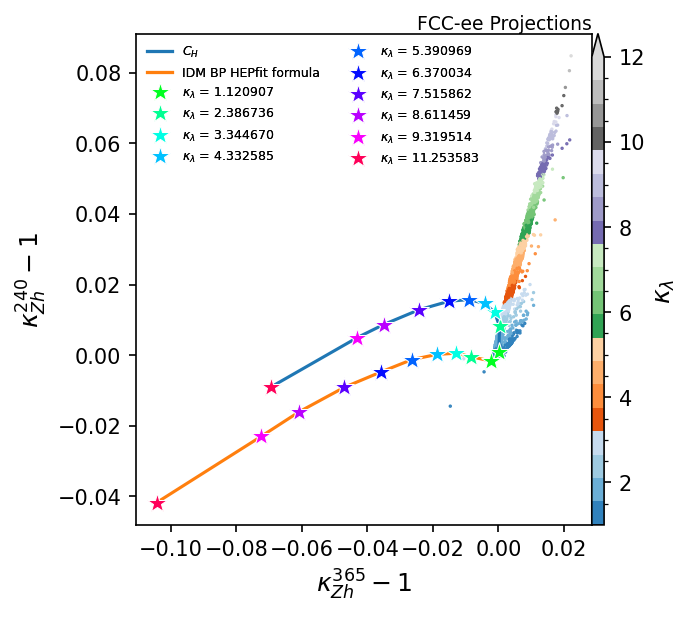

In [26]:
fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections",
                )

legend_locs = [
    None,
    'upper left',
]
legend_fontsizes = [
    6.0,
    6.0,
]
markers = [
    "*", 
    "*", 
]
markersizes = [
    10, 
    10, 
]
curves_matching_lambdas = [
    "CH_matching_lambdas", 
    "IDM_HEPfit"
]
file_names_matching_lambdas = [
    "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits/comparison_plots/k_ZH_240_365_predictions_general_lambdas.txt",
    # "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits_CHbox/comparison_plots/k_ZH_240_365_predictions_general_lambdas.txt",
    None,
]
plot_curve(curves_matching_lambdas, file_names_matching_lambdas, data_sets, legend_locs, legend_cols, markers, color_lines, label_lines, markersizes)
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"_matching_lambdas.pdf")

### Consistency check using interpolation in $C_H$ vs. $C_{Hbox}$ grid

In [27]:
input_file = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/generate_HEPfit_predictions/results/k_ZH_240_365_central_value_results.txt"

k_ZH_240 = []
k_ZH_365 = []
lmbd = []
CH = []
CHBox = []

with open(input_file, "r") as f:
    for i, line in enumerate(f):
        if i == 0:
            continue  # skip header if there is one
        columns = line.strip().split(",")
        if len(columns) < 5:
            continue  # skip malformed lines
        k_ZH_240.append(float(columns[0]))
        k_ZH_365.append(float(columns[1]))
        lmbd.append(float(columns[2]))
        CH.append(float(columns[3]))
        CHBox.append(float(columns[4]))

print(len(CH))


1620


x = [-0.02143418 -0.00486193 -0.00235785 -0.00291948 -0.00835236 -0.00685476
 -0.01279201 -0.01102742 -0.0188336  -0.01903216 -0.02646919 -0.02472826
 -0.03570123 -0.0325596  -0.04701444 -0.04504521 -0.06079483 -0.05860277
 -0.07243551 -0.07941004 -0.10432559]
y = [-4.04434798e-03 -3.50837740e-03 -1.67335129e-03 -2.28533378e-03
 -4.82537639e-04  4.95180039e-04  5.37049101e-04  2.13163358e-03
  1.72840880e-04 -6.88641953e-05 -1.31076755e-03 -1.84566243e-04
 -4.73445271e-03 -2.25330130e-03 -9.13637650e-03 -7.52604228e-03
 -1.60712256e-02 -1.48482020e-02 -2.30729895e-02 -2.63833230e-02
 -4.18256258e-02]
(21, 21)
[ 4.03916216  1.23872181         nan         nan  2.38687896  2.29677082
  3.3449273   3.31882981  4.33323819  4.32485053  5.39164508  5.29057328
  6.37065503  6.27107919  7.51637097  7.4666219   8.6119909   8.46032372
  9.32032659  9.88974161 11.25466935]
plot_points_interpolation = ((-0.0023578543246557393, -0.0016733512948496898, nan, 'BPB 0'), (-0.008352361877010273, -0.000482

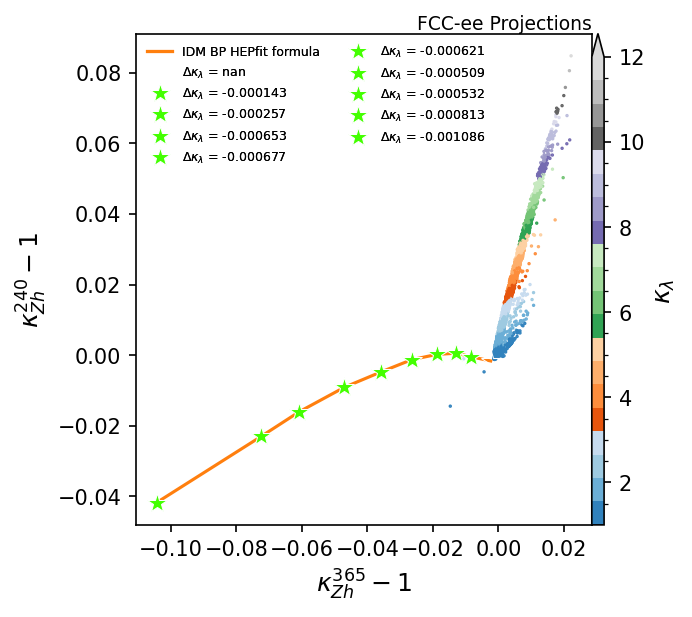

In [28]:
from scipy.interpolate import LinearNDInterpolator
import numpy as np

interp = LinearNDInterpolator(list(zip(k_ZH_365, k_ZH_240)), lmbd)

x = np.array([sqrt(smeft_sigma_Zh(lmbd=BP["lam"], sqrt_s=365) + 2*(BP["uu"]-1)) - 1 for BP in bp_kappas])
y = np.array([sqrt(smeft_sigma_Zh(lmbd=BP["lam"], sqrt_s=240) + 2*(BP["uu"]-1)) - 1 for BP in bp_kappas])
print(f"x = {x}")
print(f"y = {y}")
lmbd_BPs = np.array([BP["lam"] for BP in bp_kappas])

X, Y = np.meshgrid(np.array(x)+1, np.array(y)+1)  # 2D grid for interpolation
Z = interp(X, Y)
print(Z.shape)
# print(Z)
Z = np.array([Z[i,i] for i in range(Z.shape[0])])


# print(X)
# print(Y)
print(Z)

plot_points_interpolation = tuple(zip(x, y, lmbd_BPs-Z, BP_Names_legend))
plot_points_interpolation = plot_points_interpolation[2::2]
print(f"plot_points_interpolation = {plot_points_interpolation}")

fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections",
                )
data_sets = [
    plot_points_interpolation,
]

legend_locs = [
    'upper left',
]
legend_fontsizes = [
    6.0,
]
markers = [
    "*", 
]
markersizes = [
    10, 
]
curves_matching_lambdas = [
    "IDM_HEPfit"
]
file_names_matching_lambdas = [
    None,
]
color_lines = [
    "tab:orange",
]
label_lines = [
    r'IDM BP HEPfit formula',
]
legend_cols = [
    2,
]
legend_fontsizes = [
    6,
]
legend_point_label = r"$\Delta \kappa_{\lambda}$"
plot_curve(curves_matching_lambdas, file_names_matching_lambdas, data_sets, legend_locs, legend_cols, markers, color_lines, label_lines, markersizes, legend_point_label=legend_point_label)
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"_matching_lambdas_dkala_interp.pdf")


Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']


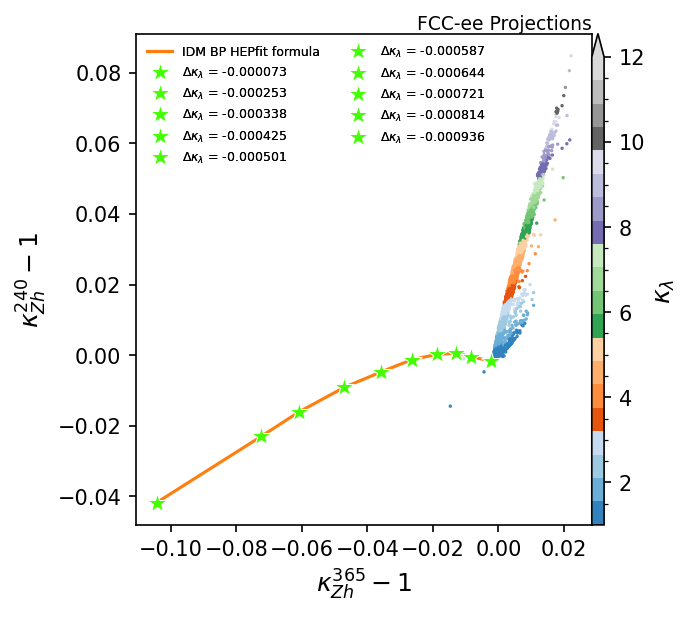

In [29]:
plot_points_analytical_formula = []
for BP, label in zip(bp_kappas, BP_Names_legend):
    k_ZH_365 = sqrt(smeft_sigma_Zh(lmbd=BP["lam"], sqrt_s=365) + 2*(BP["uu"]-1))
    k_ZH_240 = sqrt(smeft_sigma_Zh(lmbd=BP["lam"], sqrt_s=240) + 2*(BP["uu"]-1))
    CH, CHBox, lmbd = analytical_formula(mu_240=k_ZH_240**2, mu_365=k_ZH_365**2)

    plot_points_analytical_formula.append((k_ZH_365-1, k_ZH_240-1, BP["lam"]-lmbd, label))

plot_points_analytical_formula = plot_points_analytical_formula[2::2]
data_sets = [
    plot_points_analytical_formula,
]

fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections",
                )

plot_curve(curves_matching_lambdas, file_names_matching_lambdas, data_sets, legend_locs, legend_cols, markers, color_lines, label_lines, markersizes, legend_point_label=legend_point_label)
# plt.show()
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"_matching_lambdas_dkala_analytical.pdf")

## Interpolation of $C_H$ vs $C_{Hbox}$ curve

CH values for IDM BPs: [ -0.27356358  -3.00840531  -5.06677076  -7.18922198  -9.45944754
 -11.56287914 -14.01502292 -16.36477805 -17.89280176 -22.03756072]
CH values for IDM BPs (sorted): [-22.03756072 -17.89280176 -16.36477805 -14.01502292 -11.56287914
  -9.45944754  -7.18922198  -5.06677076  -3.00840531  -0.27356358]
CHbox values for IDM BPs: [-0.04128562 -0.14302313 -0.19120722 -0.24003791 -0.28308977 -0.33146349
 -0.36362348 -0.40744107 -0.45990313 -0.52884078]
CHbox values for IDM BPs (sorted): [-0.52884078 -0.45990313 -0.40744107 -0.36362348 -0.33146349 -0.28308977
 -0.24003791 -0.19120722 -0.14302313 -0.04128562]
CH curve: [-22.   -21.12 -20.24 -19.36 -18.48 -17.6  -16.72 -15.84 -14.96 -14.08
 -13.2  -12.32 -11.44 -10.56  -9.68  -8.8   -7.92  -7.04  -6.16  -5.28
  -4.4   -3.52  -2.64  -1.76  -0.88   0.  ]
CHbox curve: [-0.52821606 -0.51357947 -0.49894288 -0.48430629 -0.4696697  -0.44985028
 -0.419637   -0.39765515 -0.38124515 -0.36483515 -0.35293441 -0.34139317
 -0.32863758 -0.3

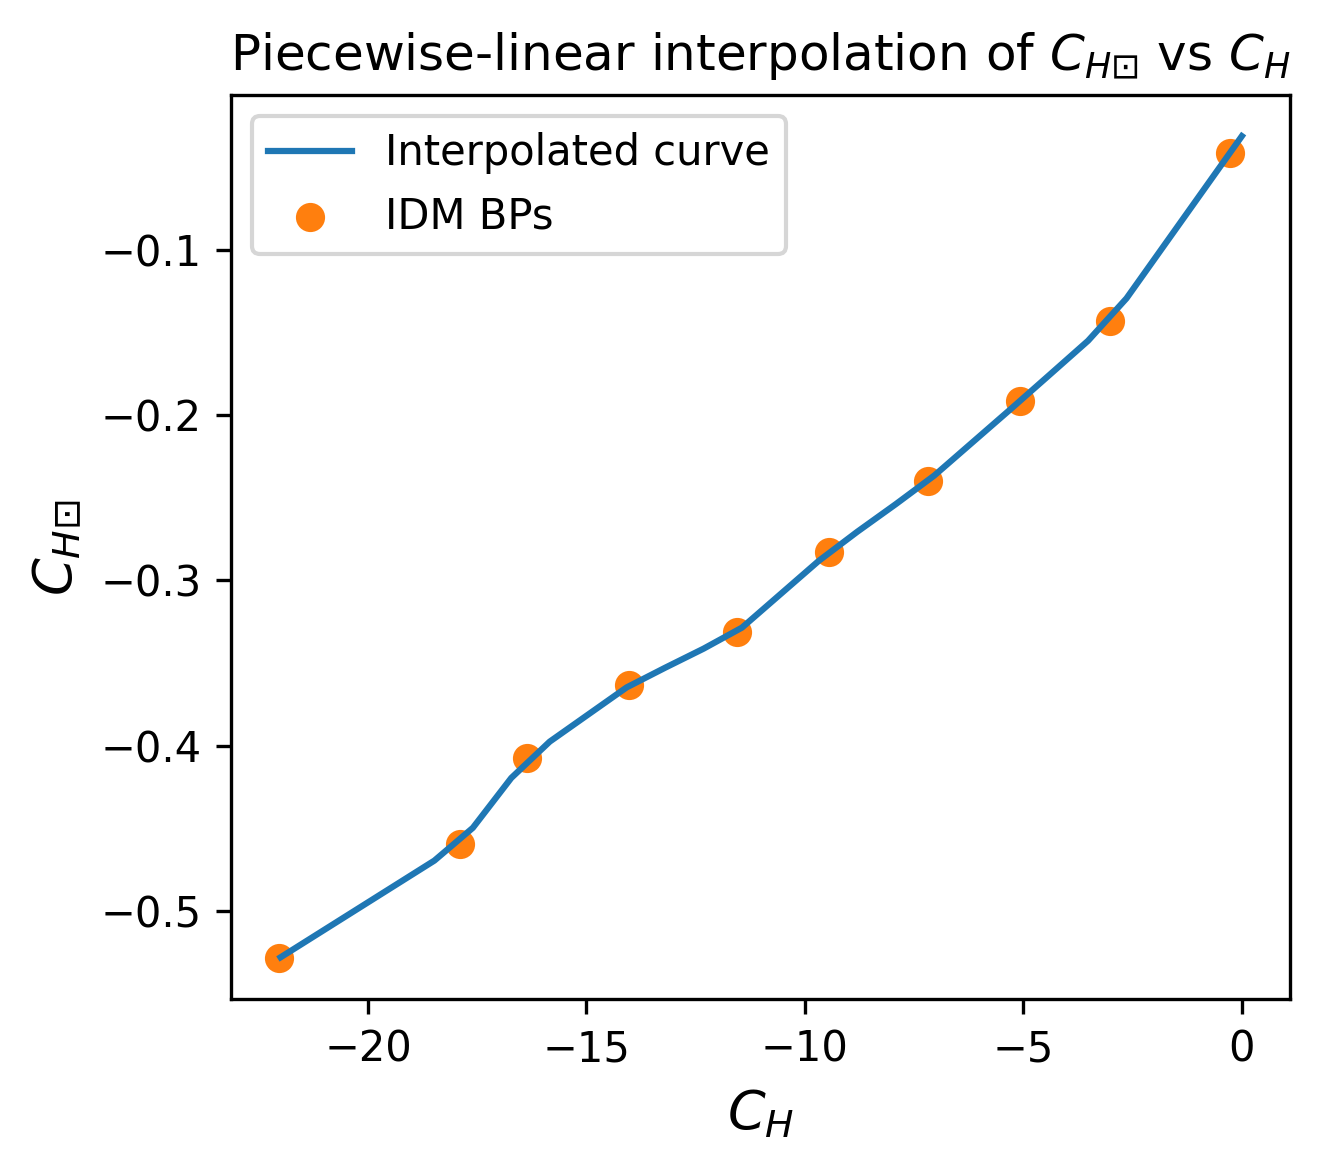

In [30]:
# from scipy.interpolate import CubicSpline
from scipy.interpolate import make_interp_spline


CH_BPs = []
CHbox_BPs = []
for BP in bp_kappas:
    k_ZH_365 = sqrt(smeft_sigma_Zh(lmbd=BP["lam"], sqrt_s=365) + 2*(BP["uu"]-1))
    k_ZH_240 = sqrt(smeft_sigma_Zh(lmbd=BP["lam"], sqrt_s=240) + 2*(BP["uu"]-1))
    CH, CHBox, lmbd = analytical_formula(mu_240=k_ZH_240**2, mu_365=k_ZH_365**2)
    CH_BPs.append(CH)
    CHbox_BPs.append(CHBox)


CH_BPs = np.array(CH_BPs[2::2])
CHbox_BPs = np.array(CHbox_BPs[2::2])

sorted_indices = np.argsort(CH_BPs)
CH_BPs_sorted = CH_BPs[sorted_indices]
CHbox_BPs_sorted = CHbox_BPs[sorted_indices]

print(f"CH values for IDM BPs: {CH_BPs}")
print(f"CH values for IDM BPs (sorted): {CH_BPs_sorted}")
print(f"CHbox values for IDM BPs: {CHbox_BPs}")
print(f"CHbox values for IDM BPs (sorted): {CHbox_BPs_sorted}")
# CH_CHbox_interpolator = CubicSpline(CH_BPs_sorted, CHbox_BPs_sorted)
spline_degree = 1  # Linear interpolation
CH_CHbox_interpolator = make_interp_spline(CH_BPs_sorted, CHbox_BPs_sorted, k=spline_degree)

CH_curve = np.linspace(-22, 0, 26)
CHbox_curve = CH_CHbox_interpolator(CH_curve)
print(f"CH curve: {CH_curve}")
print(f"CHbox curve: {CHbox_curve}")

fig, ax = plt.subplots(figsize=(4.5, 4.),dpi=300)
plt.plot(CH_curve, CHbox_curve, label="Interpolated curve", color="tab:blue")
plt.scatter(CH_BPs, CHbox_BPs, color="tab:orange", label="IDM BPs")
plt.xlabel(r"$C_{H}$", fontsize=13)
plt.ylabel(r"$C_{H\boxdot}$", fontsize=13)
plt.title(r"Cubic spline interpolation of $C_{H\boxdot}$ vs $C_{H}$")
plt.title(r"Piecewise-linear interpolation of $C_{H\boxdot}$ vs $C_{H}$")
plt.legend()
plt.tight_layout()
plt.savefig(f'{plot_dir}/{plot_name}'+"_CH_CHbox_Cubic_spline_interpolation.pdf")


output_dir = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/IDM_fits/Uncertainty_estimation/"
with open(f"{output_dir}/CH_CHbox_interpolator_results.txt", "w") as f:
    for i in range(len(CH_curve)):
        f.write(f"{CH_curve[i]},{CHbox_curve[i]}\n")

with open(f"{output_dir}/CH_CHbox_BPs.txt", "w") as f:
    for i in range(len(CH_BPs)):
        f.write(f"{CH_BPs[i]},{CHbox_BPs[i]}\n")


## Plotting results for different calculation methods

In [31]:
import math
def plot_curve_CH_CHbox (
    ax,
    curves, 
    file_names, 
    data_sets, 
    legend_locs, 
    legend_cols, 
    markers, 
    color_lines, 
    label_lines, 
    markersizes, 
    legend_point_label=None, 
    with_markers=False,
    n_markers=5,
):

    colors = mpl.colormaps['hsv']
    norm = Normalize(vmin=-5.0, vmax=12.)

    # lambdas = {}
    k_ZH_240 = {}
    k_ZH_365 = {}
    CH_values = {}
    CHbox_values = {}

    leg_handles = []
    for index, (curve, file_name, data_set, legend_loc, legend_col, legend_fontsize, marker, color_line, label_line, markersize) in enumerate(zip(curves, file_names, data_sets, legend_locs, legend_cols, legend_fontsizes, markers, color_lines, label_lines, markersizes)):

        # lambdas[curve] = []
        CH_values[curve] = []
        CHbox_values[curve] = []
        k_ZH_240[curve] = {}
        k_ZH_365[curve] = {}

        if file_name is not None and data_set is None:

            with open(file_name, "r") as self_consistent_results_file:
                lines = self_consistent_results_file.readlines()
                for n, line in enumerate(lines):
                    columns = line.split()

                    # if curve=='CH':
                    #     lmbd = int(columns[0])
                    # elif curve=='CHbox':
                    #     lmbd = float(columns[0])
                    # else:
                    #     lmbd = float(columns[0])

                    # lambdas[curve].append(lmbd)
                    CH = float(columns[0])
                    CHbox = float(columns[1])
                    CH_values[curve].append(CH)
                    CHbox_values[curve].append(CHbox)

                    if columns[-2].startswith("eeZH_FCCee240"):
                        k_ZH_240[curve][CH] = np.sqrt(float(columns[-1]))
                    elif columns[-2].startswith("eeZH_FCCee365"):
                        k_ZH_365[curve][CH] = np.sqrt(float(columns[-1]))

            CH_values[curve] = CH_values[curve][::2]
            CHbox_values[curve] = CHbox_values[curve][::2]

            # lambdas_unique = [lmbd for i, lmbd in enumerate(lambdas[curve]) if i%2==0 ]

        elif file_name is None and data_set is not None:
            for bp in data_set:
                CH = bp[2]
                CH_values[curve].append(CH)
                k_ZH_365[curve][CH] = bp[0] + 1
                k_ZH_240[curve][CH] = bp[1] + 1
        else:
            error_message = f"Please specify valid curves / files!"
            error_message += f"\nCurve: {curve}, File name: {file_name}, Data set: {data_set}"
            error_message += f"legend_loc: {legend_loc}, legend_col: {legend_col}, legend_fontsize: {legend_fontsize}"
            error_message += f"marker: {marker}, color_line: {color_line}, label_line: {label_line}, markersize: {markersize}"
            print(error_message)
            raise ValueError("Please specify valid curves / files!")

        # print(CH_values[curve])
        # print(CHbox_values[curve])
        # print(k_ZH_240[curve])
        # print(k_ZH_365[curve])
        
        color = list(colors(np.linspace(0.001, 0.9, len(CH_values[curve]))[::-1]))
        # color = list(colors(norm(-np.array(CH_values[curve]))))
        # print("color:", color)

        ax.plot([(k_ZH_365[curve][CH]-1) for CH in CH_values[curve]],
                [(k_ZH_240[curve][CH]-1) for CH in CH_values[curve]],
                color=color_line,
        )
        if legend_loc is not None:
            leg_handles.append(Line2D([0], [0], color="k", ls="-", c=color_line, label=label_line))
        else:
            leg_handles.insert(index, Line2D([0], [0], color="k", ls="-", c=color_line, label=label_line))
            # leg_handles = [Line2D([0], [0], color="k", ls="-", c=color_line, label=label_line)] + leg_handles

        if with_markers:
            for i, CH in enumerate(CH_values[curve]):
                if not i % math.ceil(len(CH_values[curve])/n_markers)==0:
                    continue

                ax.plot((k_ZH_365[curve][CH]-1), (k_ZH_240[curve][CH]-1), marker=marker, ls="none", c=color[i], markersize=markersize, markeredgecolor='white', markeredgewidth=0.5)

                # if legend_point_label is None:
                #     kala = "$\kappa_\lambda$"
                # else:
                #     kala = legend_point_label
                # if isinstance(lmbd, int):
                #     point_label = rf"{kala} = {lmbd}"
                # else:
                #     point_label = rf"{kala} = {lmbd:.6f}"
                
                # if legend_loc is not None:
                #     leg_handles.append(Line2D([0], [0], color="k", ls="none", marker=marker, c=color[i], markersize=markersize, markeredgecolor='white', markeredgewidth=0.5, label=point_label))

        if legend_loc is not None:
            hsLegend = ax.legend(
                handles=leg_handles,
                loc=legend_loc,
                frameon=False,
                prop={'size': legend_fontsize},
                ncol=legend_col,
            )
            ax.add_artist(hsLegend)

            leg_handles = []

Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']
Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']


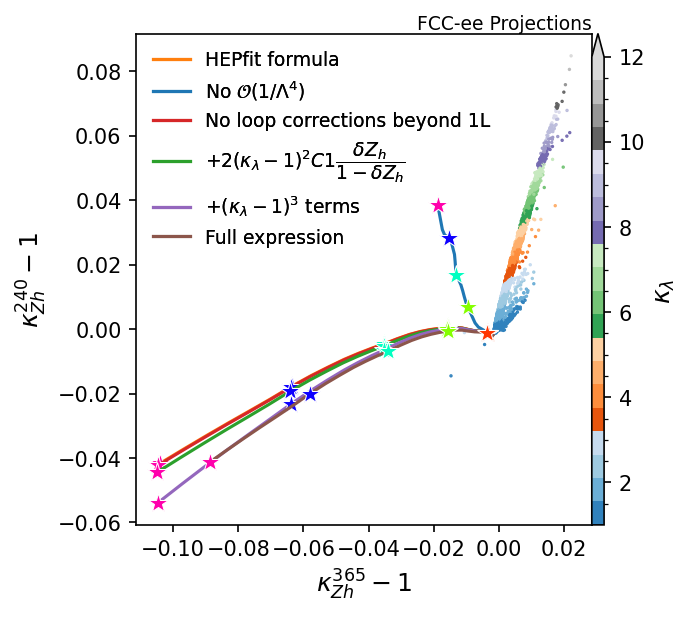

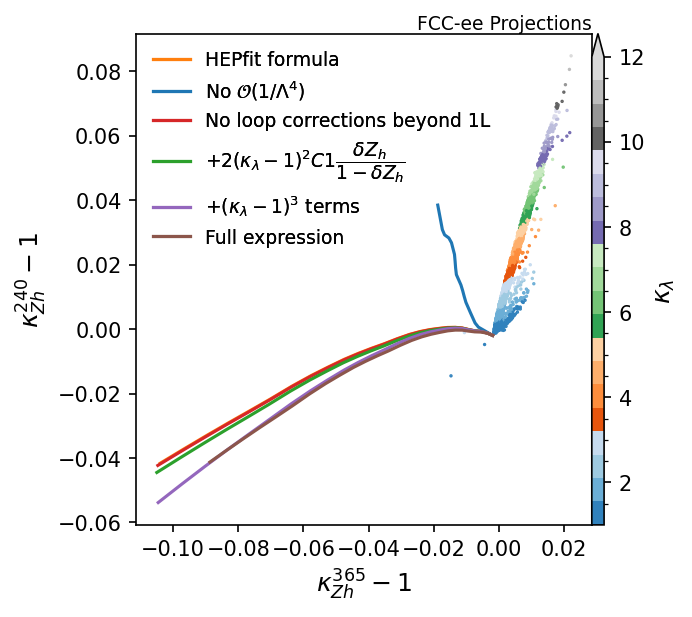

In [32]:
data_file = ["data/IDM/allIDMpoints_2025-01-14",
             "data/IDM/outlierIDMpoints_2025-01-17",
             "data/IDM/outlierIDMpoints2_2025-01-17",
             "data/IDM/outlierIDMpoints3_2025-01-17",
             "data/IDM/outlierIDMpoints4_2025-01-17",
             ]

plot_dir = "plots/IDM"
plot_name = "IDM_results_k_ZH_240_vs_365"
plot_name_suffix = "_with_self_consistent_curves_SMEFT_formula"

fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections",
                )

legend_locs = [
    None,
    None,
    None,
    None,
    None,
    "upper left",
    # 'upper left',
]
legend_fontsizes = [
    9.0,
    9.0,
    9.0,
    9.0,
    9.0,
    9.0,
]
markers = [
    "*", 
    "*", 
    "*", 
    "*", 
    "*", 
    "*", 
]
markersizes = [
    10, 
    10, 
    10, 
    10, 
    10, 
    10, 
]
color_lines = [
    "tab:orange",
    "tab:blue",
    "tab:red",
    "tab:green",
    "tab:purple",
    "tab:brown",
]
label_lines = [
    r'HEPfit formula',
    r'No $\mathcal{O}(1/\Lambda^4)$',
    r'No loop corrections beyond 1L',
    r'$+ 2(\kappa_{\lambda}-1)^2 C1 \dfrac{\delta Z_h}{1-\delta Z_h}$',
    r'$+(\kappa_{\lambda}-1)^3$ terms',
    r'Full expression',
]
legend_cols = [
    1,
    1,
    1,
    1,
    1,
    1,
]
curves_uncertainty_estimation = [
    "HEPfit", 
    "noLoopH3d6Quad",
    "LoopHd6NoSubleading",
    "LoopH3d6Quad_C1term",
    "LoopH3d6Cubi",
    "LoopH3d6Full",
]
data_sets = [
    None,
    None,
    None,
    None,
    None,
    None,
]
results_directory = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/IDM_fits/Uncertainty_estimation/comparison_plots"
k_ZH_240_365_predictions_file_names = [
    f"{results_directory}/k_ZH_240_365_predictions.txt",
    f"{results_directory}/k_ZH_240_365_predictions_noLoopH3d6Quad.txt",
    f"{results_directory}/k_ZH_240_365_predictions_LoopHd6NoSubleading.txt",
    f"{results_directory}/k_ZH_240_365_predictions_LoopH3d6Quad_C1term.txt",
    f"{results_directory}/k_ZH_240_365_predictions_LoopH3d6Cubi.txt",
    f"{results_directory}/k_ZH_240_365_predictions_LoopH3d6Full.txt",
]

plot_curve_CH_CHbox(
    ax,
    curves_uncertainty_estimation, 
    k_ZH_240_365_predictions_file_names, 
    data_sets, 
    legend_locs, 
    legend_cols, 
    markers, 
    color_lines, 
    label_lines, 
    markersizes,
    with_markers=True
)
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"_comparison_uncertainty_estimation_markers.pdf")


fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections",
                )
plot_curve_CH_CHbox(
    ax,
    curves_uncertainty_estimation, 
    k_ZH_240_365_predictions_file_names, 
    data_sets, 
    legend_locs, 
    legend_cols, 
    markers, 
    color_lines, 
    label_lines, 
    markersizes,
    with_markers=False,
)
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"_comparison_uncertainty_estimation.pdf")

### Plots including SM higgs contribution to WFR into IDM BPs

Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']
Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']
Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']


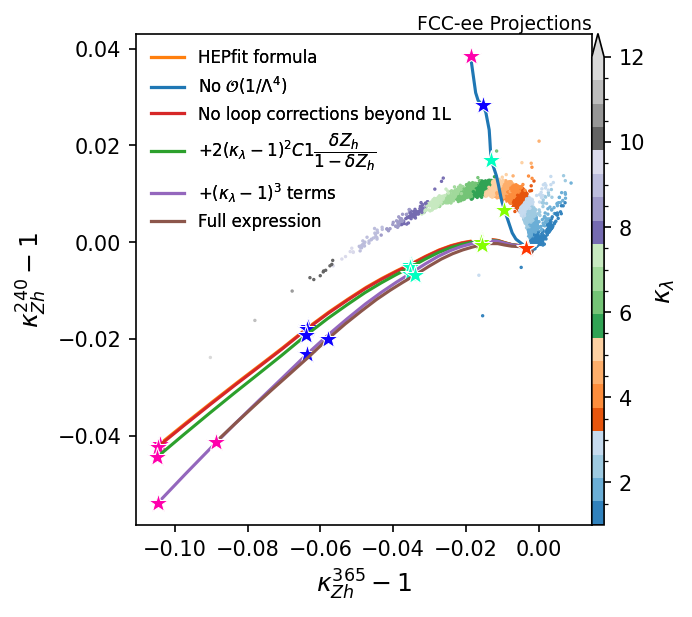

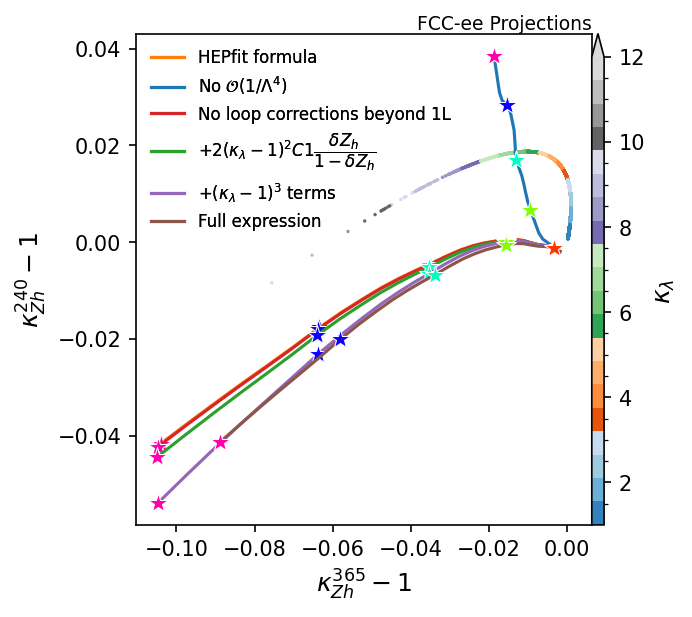

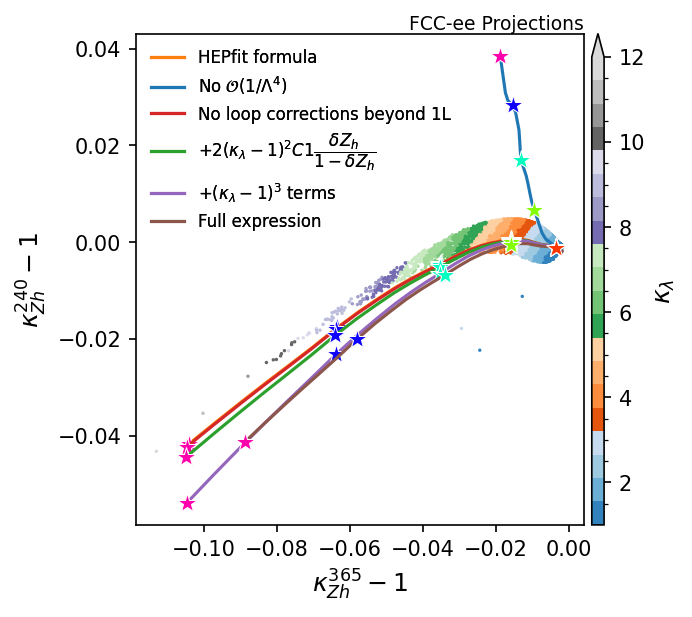

In [33]:
legend_fontsizes = [
    8.0,
    8.0,
    8.0,
    8.0,
    8.0,
    8.0,
]

#####################
### data_with_WFR ###
#####################
fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections",
                        data_with_WFR=True,
                )
plot_curve_CH_CHbox(
    ax,
    curves_uncertainty_estimation, 
    k_ZH_240_365_predictions_file_names, 
    data_sets, 
    legend_locs, 
    legend_cols, 
    markers, 
    color_lines, 
    label_lines, 
    markersizes,
    with_markers=True,
)
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"_comparison_uncertainty_estimation_markers_with_IDM_WFR.pdf")



###################################
### data_with_WFR_no_BSM_vertex ###
###################################
fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections",
                        data_with_WFR=False,
                        data_with_WFR_no_BSM_vertex=True,
                )
plot_curve_CH_CHbox(
    ax,
    curves_uncertainty_estimation, 
    k_ZH_240_365_predictions_file_names, 
    data_sets, 
    legend_locs, 
    legend_cols, 
    markers, 
    color_lines, 
    label_lines, 
    markersizes,
    with_markers=True,
)
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"_comparison_uncertainty_estimation_markers_with_IDM_WFR_no_BSM_vertex.pdf")


#######################################
### data_with_WFR_ZZh1L_hextlegonly ###
#######################################
fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections",
                        data_with_WFR=False,
                        data_with_WFR_no_BSM_vertex=False,
                        data_with_WFR_ZZh1L_hextlegonly=True
                )
plot_curve_CH_CHbox(
    ax,
    curves_uncertainty_estimation, 
    k_ZH_240_365_predictions_file_names, 
    data_sets, 
    legend_locs, 
    legend_cols, 
    markers, 
    color_lines, 
    label_lines, 
    markersizes,
    with_markers=True,
)
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"_comparison_uncertainty_estimation_markers_with_IDM_WFR_ZZh1L_hextlegonly.pdf")
# fig_uncertainty = fig; ax_uncertainty = ax

### Estimating uncertainty with ellipses

Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']


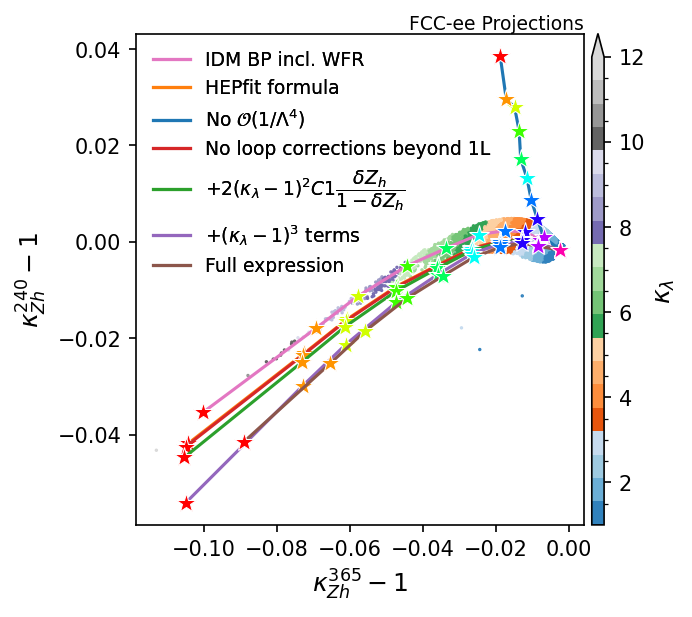

In [34]:
#######################################
### data_with_WFR_ZZh1L_hextlegonly ###
#######################################
fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections",
                        data_with_WFR=False,
                        data_with_WFR_no_BSM_vertex=False,
                        data_with_WFR_ZZh1L_hextlegonly=True
                )

plot_points_with_WFR = [
    (BP["ZZ_365_with_WFR_ZZh1L_hextlegonly"] - 1,
     BP["ZZ_240_with_WFR_ZZh1L_hextlegonly"] - 1,
     BP["lam"],
     label, ) for BP, label in zip(bp_kappas, BP_Names_legend)
]
plot_points_with_WFR = plot_points_with_WFR[2::2]
# plot_points_with_WFR = plot_points_with_WFR[::-1] 

legend_locs = [
    None,
    None,
    None,
    None,
    None,
    None,
    "upper left",
    # 'upper left',
]
legend_fontsizes = [
    9.0,
    9.0,
    9.0,
    9.0,
    9.0,
    9.0,
    9.0,
]
markers = [
    "*", 
    "*", 
    "*", 
    "*", 
    "*", 
    "*", 
    "*", 
]
markersizes = [
    10, 
    10, 
    10, 
    10, 
    10, 
    10, 
    10, 
]
color_lines = [
    "tab:pink",
    "tab:orange",
    "tab:blue",
    "tab:red",
    "tab:green",
    "tab:purple",
    "tab:brown",
]
label_lines = [
    r'IDM BP incl. WFR',
    r'HEPfit formula',
    r'No $\mathcal{O}(1/\Lambda^4)$',
    r'No loop corrections beyond 1L',
    r'$+ 2(\kappa_{\lambda}-1)^2 C1 \dfrac{\delta Z_h}{1-\delta Z_h}$',
    r'$+(\kappa_{\lambda}-1)^3$ terms',
    r'Full expression',
]
legend_cols = [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
]
curves_uncertainty_estimation = [
    "IDM",
    "HEPfit", 
    "noLoopH3d6Quad",
    "LoopHd6NoSubleading",
    "LoopH3d6Quad_C1term",
    "LoopH3d6Cubi",
    "LoopH3d6Full",
]
data_sets = [
    plot_points_with_WFR,
    None,
    None,
    None,
    None,
    None,
    None,
]
results_directory = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/IDM_fits/Uncertainty_estimation/comparison_plots"
k_ZH_240_365_predictions_file_names = [
    None,
    f"{results_directory}/k_ZH_240_365_predictions_BPs_.txt",
    f"{results_directory}/k_ZH_240_365_predictions_BPs__noLoopH3d6Quad.txt",
    f"{results_directory}/k_ZH_240_365_predictions_BPs__LoopHd6NoSubleading.txt",
    f"{results_directory}/k_ZH_240_365_predictions_BPs__LoopH3d6Quad_C1term.txt",
    f"{results_directory}/k_ZH_240_365_predictions_BPs__LoopH3d6Cubi.txt",
    f"{results_directory}/k_ZH_240_365_predictions_BPs__LoopH3d6Full.txt",
]
plot_curve_CH_CHbox(
    ax,
    curves_uncertainty_estimation, 
    k_ZH_240_365_predictions_file_names, 
    data_sets, 
    legend_locs, 
    legend_cols, 
    markers, 
    color_lines, 
    label_lines, 
    markersizes,
    with_markers=True,
    n_markers=10
)
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"uncertainty_with_IDM_WFR_ZZh1L_hextlegonly_BPs.pdf")

Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']


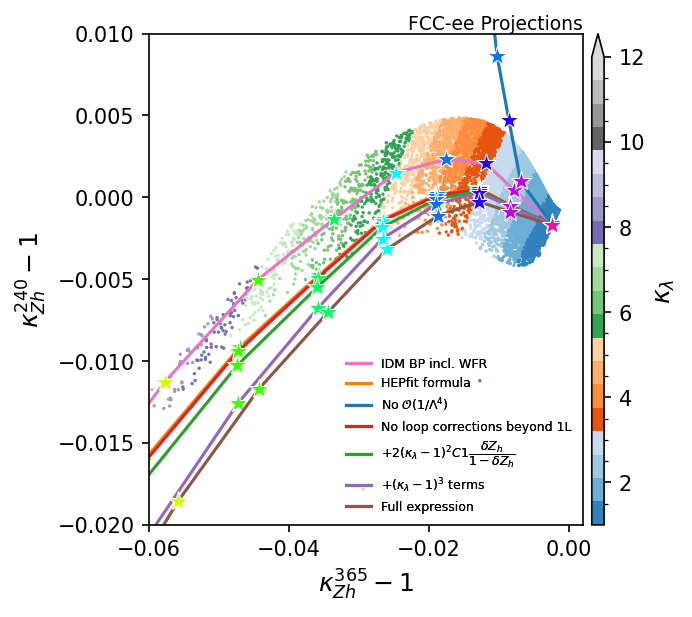

In [35]:
fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections",
                        data_with_WFR=False,
                        data_with_WFR_no_BSM_vertex=False,
                        data_with_WFR_ZZh1L_hextlegonly=True
                )
legend_locs = [
    None,
    None,
    None,
    None,
    None,
    None,
    'lower right',
]
legend_fontsizes = [
    6.0,
    6.0,
    6.0,
    6.0,
    6.0,
    6.0,
    6.0,
]
plot_curve_CH_CHbox(
    ax,
    curves_uncertainty_estimation, 
    k_ZH_240_365_predictions_file_names, 
    data_sets, 
    legend_locs, 
    legend_cols, 
    markers, 
    color_lines, 
    label_lines, 
    markersizes,
    with_markers=True,
    n_markers=10
)

ax.set_xlim(-0.06, +0.002)
ax.set_ylim(-0.02, +0.01)
fig.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"uncertainty_with_IDM_WFR_ZZh1L_hextlegonly_BPs_zoom.pdf")

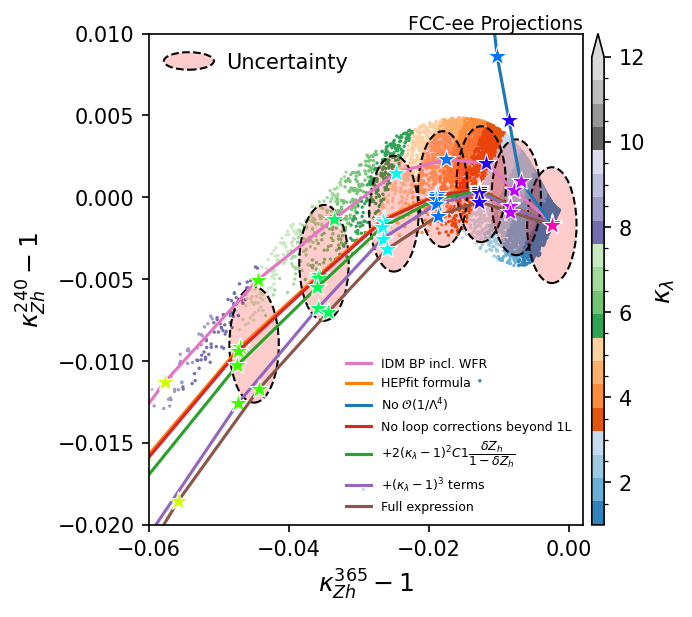

In [36]:
from matplotlib.patches import Ellipse, Circle

xs     = [-2.4e-3, -0.0075, -0.0125, -0.018, -0.025, -0.035, -0.045, ]
ys     = [-1.7e-3, -0.0e-4, 0.0008,  0.0005, -0.001, -0.004, -0.009, ]
err_xs = [ sqrt(2) * 0.005 / 2. for x in xs]
err_ys = [ sqrt(2) * 0.005 / 2. for x in xs]
black = (0,0,0,1)
red_face = (1,0,0,0.2)
for x, y, err_x, err_y in zip(xs, ys, err_xs, err_ys):
    ellipse = Ellipse((x, y), width=err_x*2, height=err_y*2, edgecolor=black, facecolor=red_face, linestyle='--')
    ax.add_patch(ellipse)

from matplotlib.legend_handler import HandlerPatch

class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = Ellipse(xy=center, width=1.2*width + xdescent,
                               height=1.2*height + ydescent)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]
    
ax.legend(handles=[ellipse], labels=[r"Uncertainty"], loc='upper left', fontsize=10.0, frameon=False, handler_map={Ellipse: HandlerEllipse()})

fig.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"uncertainty_with_IDM_WFR_ZZh1L_hextlegonly_BPs_zoom_ellipses_0.005.pdf")
fig

Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']


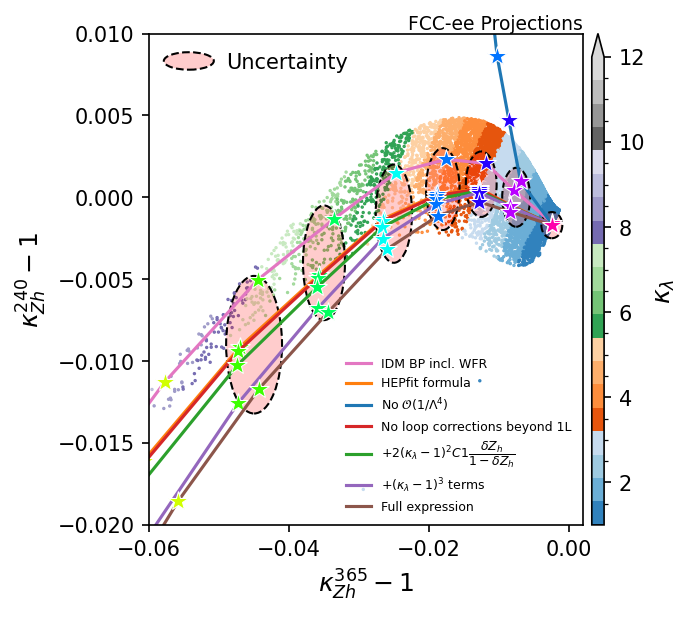

In [37]:
fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections",
                        data_with_WFR=False,
                        data_with_WFR_no_BSM_vertex=False,
                        data_with_WFR_ZZh1L_hextlegonly=True
                )
            
legend_locs = [
    None,
    None,
    None,
    None,
    None,
    None,
    'lower right',
]
legend_fontsizes = [
    6.0,
    6.0,
    6.0,
    6.0,
    6.0,
    6.0,
    6.0,
]
plot_curve_CH_CHbox(
    ax,
    curves_uncertainty_estimation, 
    k_ZH_240_365_predictions_file_names, 
    data_sets, 
    legend_locs, 
    legend_cols, 
    markers, 
    color_lines, 
    label_lines, 
    markersizes,
    with_markers=True,
    n_markers=10
)

ax.set_xlim(-0.06, +0.002)
ax.set_ylim(-0.02, +0.01)

xs     = [-2.4e-3, -0.0075, -0.0125, -0.018, -0.025, -0.035, -0.045, ]
ys     = [-1.7e-3, -0.0e-4, 0.0008,  0.0005, -0.001, -0.004, -0.009, ]
err_xs = [1.5e-3,  2.0e-3, 2.2e-3,  2.4e-3, 2.6e-3, 3.0e-3, 4e-3,   ]
err_ys = [8.0e-4,  1.8e-3, 2.0e-3,  2.5e-3, 3.0e-3, 3.5e-3, 4.2e-3, ] 
black = (0,0,0,1)
red_face = (1,0,0,0.2)
for x, y, err_x, err_y in zip(xs, ys, err_xs, err_ys):
    ellipse = Ellipse((x, y), width=err_x*2, height=err_y*2, edgecolor=black, facecolor=red_face, linestyle='--')
    ax.add_patch(ellipse)

class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = Ellipse(xy=center, width=1.2*width + xdescent,
                               height=1.2*height + ydescent)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]
    
ax.legend(handles=[ellipse], labels=[r"Uncertainty"], loc='upper left', fontsize=10.0, frameon=False, handler_map={Ellipse: HandlerEllipse()})


fig.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"uncertainty_with_IDM_WFR_ZZh1L_hextlegonly_BPs_zoom_ellipses.pdf")

klam = [1.1209067864736006, 2.3867362274064843, 3.3446699219962595, 4.332584967850238, 5.390968560325193, 6.370034303736775, 7.515862276796717]
Mean k_Zh uncertainties: 240: 0.0011625, 365: 0.00115
kappas_Zh_365 = [0.9976925397371732, 0.9922185234979847, 0.9881639572406814, 0.9825134483196111, 0.9752910355098184, 0.9664394848848527, 0.9555670439793632, 0.9422118613961943, 0.930854117220499, 0.8997406285316758]
kappas_Zh_240 = [0.9984072024003215, 1.0004295209531087, 1.002063854015035, 1.0023236553718364, 1.0014989491505055, 0.9986813716599217, 0.9949808105424701, 0.9887204875563975, 0.9821652077679434, 0.9646303586739049]
mean_kappas_Zh = [0.9819894803567036, 1.0019621528457925]
Mean sigma_Zh uncertainties: 240: 0.0023295620053664676, 365: 0.0022585758048204183


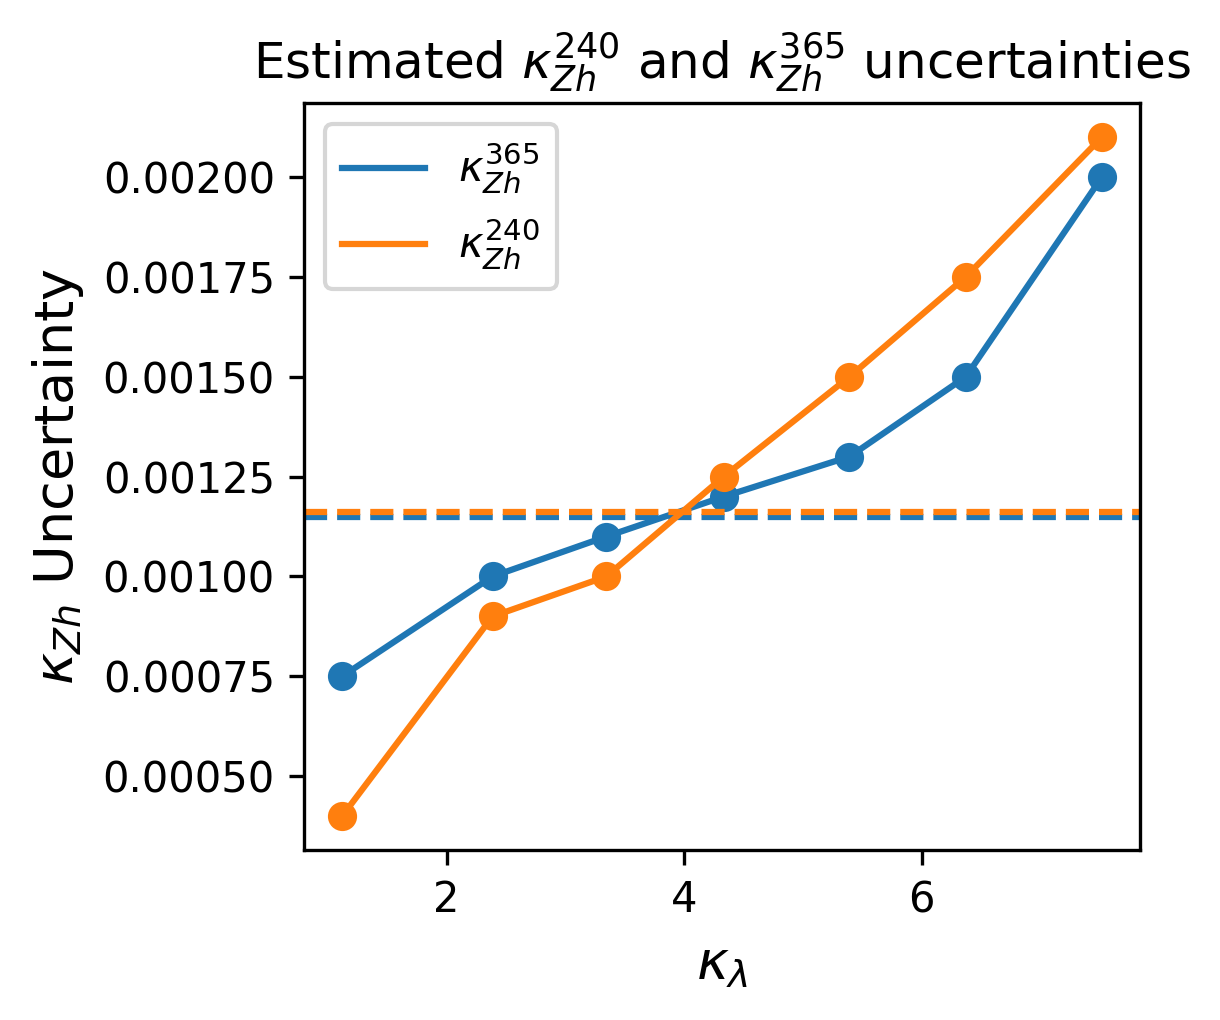

In [38]:
fig, ax = plt.subplots(figsize=(4.0, 3.5), dpi=300)
curves = [0.5*np.array(err_xs), 0.5*np.array(err_ys)]
labels = [r"$\kappa_{Zh}^{365}$", r"$\kappa_{Zh}^{240}$"]
colors = ["tab:blue", "tab:orange",]

mean_uncertainties_kappa = [np.mean(curve[1:5]) for curve in curves]

klam = [ plot_points_with_WFR[i][2] for i in range(len(err_xs)) ]
print(f"klam = {klam}")
for curve, label, color, mean in zip(curves, labels, colors, mean_uncertainties_kappa):
    plt.plot(klam, curve, label=label, color=color)
    plt.scatter(klam, curve, color=color)

    plt.axhline(y=mean, linestyle='--', linewidth=1.5, color=color)
    
plt.xlabel(r"$\kappa_\lambda$", fontsize=13)
plt.title(r"Estimated $\kappa_{Zh}^{240}$ and $\kappa_{Zh}^{365}$ uncertainties")
plt.ylabel(r"$\kappa_{Zh}$ Uncertainty", fontsize=13)
plt.legend()
plt.tight_layout()
plt.savefig(f'{plot_dir}/{plot_name}'+"k_ZH_240_365_uncertainties.pdf")

print(f"Mean k_Zh uncertainties: 240: {mean_uncertainties_kappa[1]}, 365: {mean_uncertainties_kappa[0]}")
kappas_Zh_365 = [ (lst[0]+1) for lst in plot_points_with_WFR]
print(f"kappas_Zh_365 = {kappas_Zh_365}")
kappas_Zh_240 = [ (lst[1]+1) for lst in plot_points_with_WFR]
print(f"kappas_Zh_240 = {kappas_Zh_240}")
kappas_Zh = [ kappas_Zh_365[1:5], kappas_Zh_240[1:5]]

mean_kappas_Zh = [np.mean(ks[1:5]) for ks in kappas_Zh]
print(f"mean_kappas_Zh = {mean_kappas_Zh}")
mean_uncertainties_sigma = [2*kappa*mean for kappa, mean in zip(mean_kappas_Zh, mean_uncertainties_kappa)]
print(f"Mean sigma_Zh uncertainties: 240: {mean_uncertainties_sigma[1]}, 365: {mean_uncertainties_sigma[0]}")


### Interpolation including more Wilson coefficients

CH_BPs: [ -0.67841313  -4.17826137  -7.03517638  -9.83798517 -12.96716946
 -15.97037203 -19.34209292 -22.65704704 -24.9778176  -31.0277494 ]
CHbox_BPs: [-0.07724434 -0.14578466 -0.18036846 -0.17197327 -0.1497207  -0.10240968
 -0.01493636  0.10468723  0.22605933  0.60072274]
CHD_BPs: [-0.03313977 -0.02012181 -0.02411508 -0.01692248 -0.0210066  -0.02469135
 -0.02137718 -0.02737746 -0.02382377 -0.0241148 ]
CHW_BPs: [0.00339029 0.00481544 0.00707246 0.00747625 0.00898678 0.01058458
 0.01120099 0.01428393 0.01482622 0.01790532]
CHB_BPs: [ 2.18087674e-03  3.36672666e-04 -4.89967657e-05 -1.07859582e-03
 -1.45264352e-03 -1.97646564e-03 -2.97574909e-03 -3.48284773e-03
 -4.19664296e-03 -5.64082970e-03]
CHWB_BPs: [ 0.00458944  0.00111038  0.00134835 -0.00082641 -0.001212   -0.00193137
 -0.00375185 -0.00346872 -0.00519271 -0.00696101]
Sorted indices: [9 8 7 6 5 4 3 2 1 0]


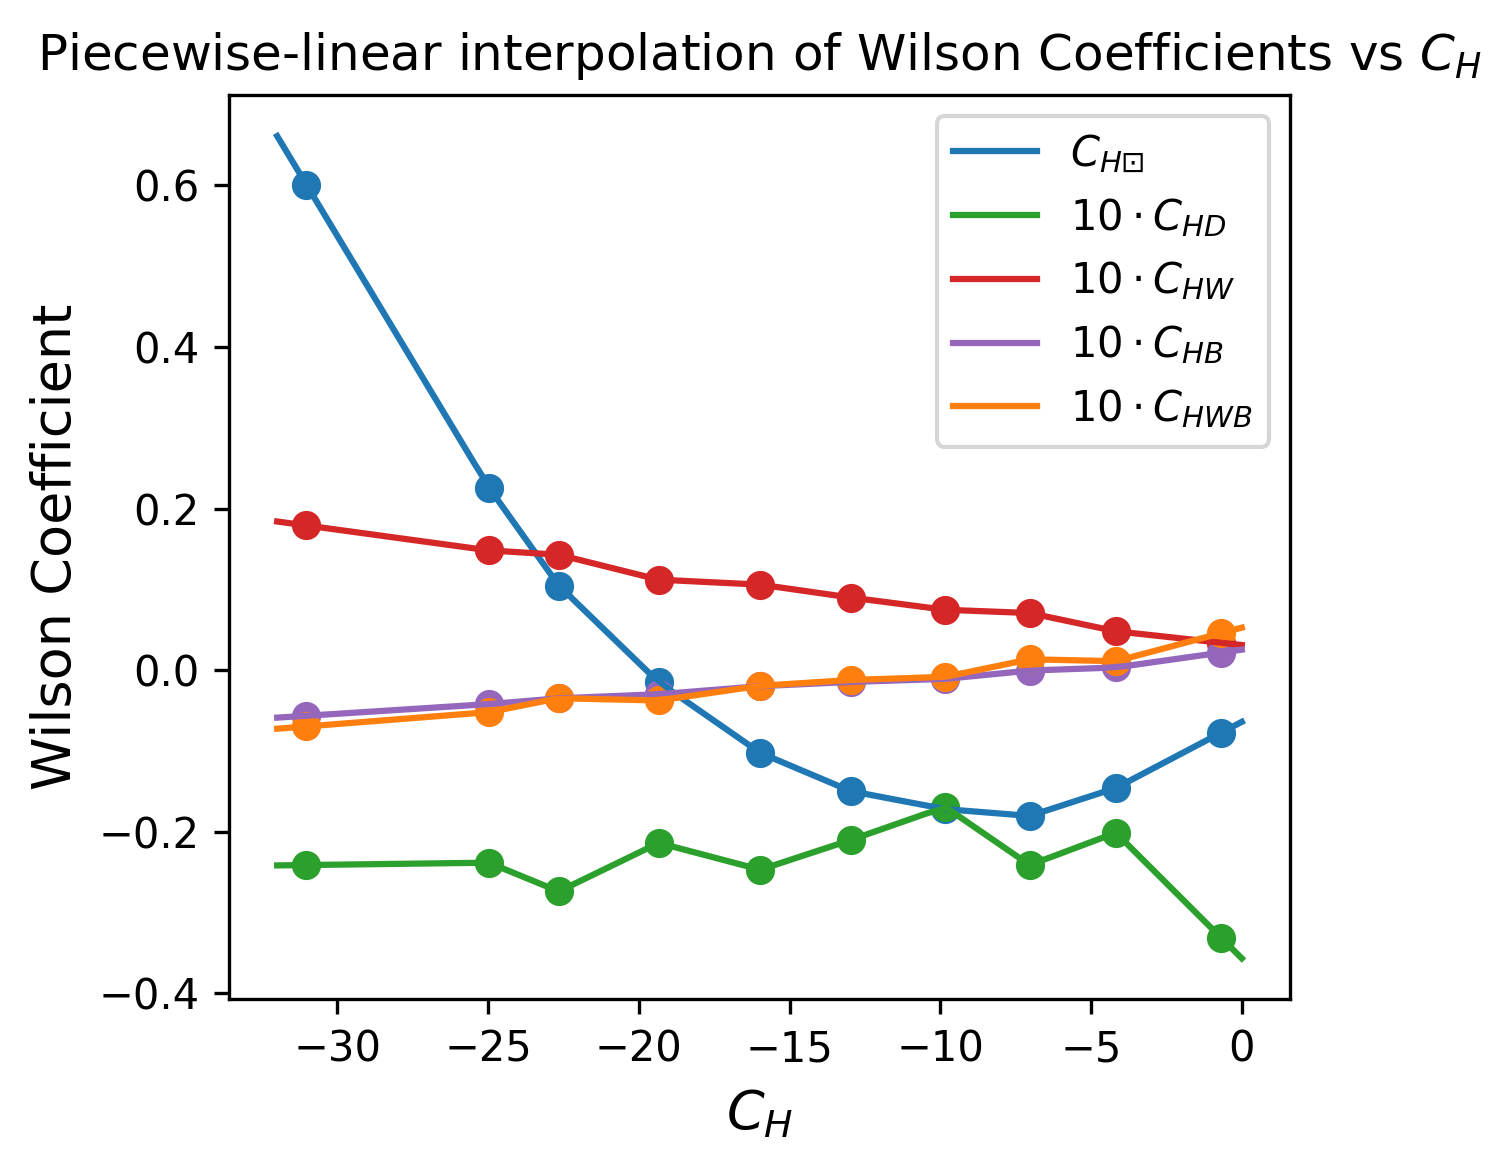

In [39]:
# from scipy.interpolate import CubicSpline
from scipy.interpolate import make_interp_spline


CH_BPs = []
CHbox_BPs = []
CHD_BPs = []
CHW_BPs = []
CHB_BPs = []
CHWB_BPs = []
input_dir = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/IDM_fits/Uncertainty_estimation/all_WCs/"
with open(f"{input_dir}WC_results.txt", 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        if i == 0:  # Skip header line
            continue

        _, CH, CHbox, CHD, CHW, CHB, CHWB = line.split(",")
        CH_BPs.append(float(CH))
        CHbox_BPs.append(float(CHbox))
        CHD_BPs.append(float(CHD))
        CHW_BPs.append(float(CHW))
        CHB_BPs.append(float(CHB))
        CHWB_BPs.append(float(CHWB))

CH_BPs    = np.array(CH_BPs[0::2])
CHbox_BPs = np.array(CHbox_BPs[0::2])
CHD_BPs   = np.array(CHD_BPs[0::2])
CHW_BPs   = np.array(CHW_BPs[0::2])
CHB_BPs   = np.array(CHB_BPs[0::2])
CHWB_BPs  = np.array(CHWB_BPs[0::2])

print(f"CH_BPs: {CH_BPs}")
print(f"CHbox_BPs: {CHbox_BPs}")
print(f"CHD_BPs: {CHD_BPs}")
print(f"CHW_BPs: {CHW_BPs}")
print(f"CHB_BPs: {CHB_BPs}")
print(f"CHWB_BPs: {CHWB_BPs}")

sorted_indices = np.argsort(CH_BPs)
print(f"Sorted indices: {sorted_indices}")
CH_BPs_sorted    = CH_BPs[sorted_indices]
CHbox_BPs_sorted = CHbox_BPs[sorted_indices]
CHD_BPs_sorted   = CHD_BPs[sorted_indices]
CHW_BPs_sorted   = CHW_BPs[sorted_indices]
CHB_BPs_sorted   = CHB_BPs[sorted_indices]
CHWB_BPs_sorted  = CHWB_BPs[sorted_indices]

# print(f"CH values for IDM BPs: {CH_BPs}")
# print(f"CH values for IDM BPs (sorted): {CH_BPs_sorted}")
# print(f"CHbox values for IDM BPs: {CHbox_BPs}")
# print(f"CHbox values for IDM BPs (sorted): {CHbox_BPs_sorted}")
spline_degree = 1  # Linear interpolation
CH_CHbox_interpolator = make_interp_spline(CH_BPs_sorted, CHbox_BPs_sorted, k=spline_degree)
CH_CHD_interpolator   = make_interp_spline(CH_BPs_sorted, CHD_BPs_sorted,   k=spline_degree)
CH_CHW_interpolator   = make_interp_spline(CH_BPs_sorted, CHW_BPs_sorted,   k=spline_degree)
CH_CHB_interpolator   = make_interp_spline(CH_BPs_sorted, CHB_BPs_sorted,   k=spline_degree)
CH_CHWB_interpolator  = make_interp_spline(CH_BPs_sorted, CHWB_BPs_sorted,  k=spline_degree)

CH_curve = np.linspace(-32, 0, 50)
CHbox_curve = CH_CHbox_interpolator(CH_curve)
CHD_curve   = CH_CHD_interpolator(CH_curve)
CHW_curve   = CH_CHW_interpolator(CH_curve)
CHB_curve   = CH_CHB_interpolator(CH_curve)
CHWB_curve  = CH_CHWB_interpolator(CH_curve)
# print(f"CH curve: {CH_curve}")
# print(f"CHbox curve: {CHbox_curve}")

WC_curves_plot = [CHbox_curve, 10*CHD_curve, 10*CHW_curve, 10*CHB_curve, 10*CHWB_curve]
WC_BPs_plot = [CHbox_BPs, 10*CHD_BPs, 10*CHW_BPs, 10*CHB_BPs, 10*CHWB_BPs]
WC_tex_labels = [r"$C_{H\boxdot}$", r"$10\cdot C_{HD}$", r"$10\cdot C_{HW}$", r"$10\cdot C_{HB}$", r"$10\cdot C_{HWB}$"]
colors = ["tab:blue", "tab:green", "tab:red", "tab:purple", "tab:orange"]

fig, ax = plt.subplots(figsize=(4.5, 4.),dpi=300)

for WC_curve, WC_BP, tex_label, color in zip(WC_curves_plot, WC_BPs_plot, WC_tex_labels, colors):
    # plt.plot(CH_curve, WC_curve, label=r"Interpolated curve "+tex_label, color=color)
    plt.plot(CH_curve, WC_curve, label=tex_label, color=color)
    plt.scatter(CH_BPs, WC_BP, color=color)
    
plt.xlabel(r"$C_{H}$", fontsize=13)
plt.title(r"Piecewise-linear interpolation of Wilson Coefficients vs $C_{H}$")
plt.ylabel(r"Wilson Coefficient", fontsize=13)
plt.legend()
plt.tight_layout()
plt.savefig(f'{plot_dir}/{plot_name}'+"_WCs_linear_interpolation.pdf")

WC_curves = [CHbox_curve, CHD_curve, CHW_curve, CHB_curve, CHWB_curve]
WC_BPs = [CHbox_BPs, CHD_BPs, CHW_BPs, CHB_BPs, CHWB_BPs]

output_dir = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/IDM_fits/Uncertainty_estimation/all_WCs"
with open(f"{output_dir}/WC_interpolator_results.txt", "w") as f:
    print(f"CH,CHbox,CHD,CHW,CHB,CHWB", file=f)
    for i in range(len(CH_curve)):
        f.write(f"{CH_curve[i]},{CHbox_curve[i]},{CHD_curve[i]},{CHW_curve[i]},{CHB_curve[i]},{CHWB_curve[i]}\n")



Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']


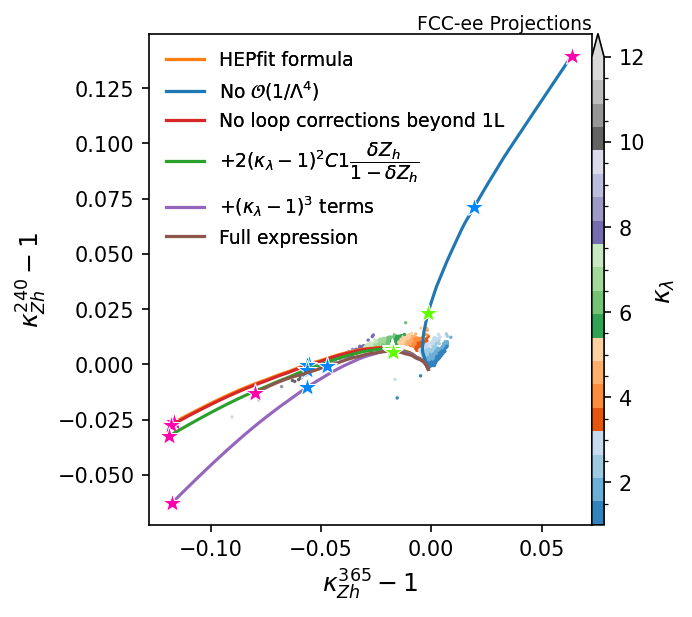

In [40]:
results_directory = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/IDM_fits/Uncertainty_estimation/all_WCs/comparison_plots"
k_ZH_240_365_predictions_file_names_all_WCs = [
    f"{results_directory}/k_ZH_240_365_predictions.txt",
    f"{results_directory}/k_ZH_240_365_predictions_noLoopH3d6Quad.txt",
    f"{results_directory}/k_ZH_240_365_predictions_LoopHd6NoSubleading.txt",
    f"{results_directory}/k_ZH_240_365_predictions_LoopH3d6Quad_C1term.txt",
    f"{results_directory}/k_ZH_240_365_predictions_LoopH3d6Cubi.txt",
    f"{results_directory}/k_ZH_240_365_predictions_LoopH3d6Full.txt",
]

legend_locs = [
    None,
    None,
    None,
    None,
    None,
    "upper left",
    # 'upper left',
]
legend_fontsizes = [
    9.0,
    9.0,
    9.0,
    9.0,
    9.0,
    9.0,
]
markers = [
    "*", 
    "*", 
    "*", 
    "*", 
    "*", 
    "*", 
]
markersizes = [
    10, 
    10, 
    10, 
    10, 
    10, 
    10, 
]
color_lines = [
    "tab:orange",
    "tab:blue",
    "tab:red",
    "tab:green",
    "tab:purple",
    "tab:brown",
]
label_lines = [
    r'HEPfit formula',
    r'No $\mathcal{O}(1/\Lambda^4)$',
    r'No loop corrections beyond 1L',
    r'$+ 2(\kappa_{\lambda}-1)^2 C1 \dfrac{\delta Z_h}{1-\delta Z_h}$',
    r'$+(\kappa_{\lambda}-1)^3$ terms',
    r'Full expression',
]
legend_cols = [
    1,
    1,
    1,
    1,
    1,
    1,
]
curves_uncertainty_estimation = [
    "HEPfit", 
    "noLoopH3d6Quad",
    "LoopHd6NoSubleading",
    "LoopH3d6Quad_C1term",
    "LoopH3d6Cubi",
    "LoopH3d6Full",
]
data_sets = [
    None,
    None,
    None,
    None,
    None,
    None,
]


fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections",
                        data_with_WFR=True,
                        data_with_WFR_no_BSM_vertex=False,
                )
plot_curve_CH_CHbox(
    ax,
    curves_uncertainty_estimation, 
    k_ZH_240_365_predictions_file_names_all_WCs, 
    data_sets, 
    legend_locs, 
    legend_cols, 
    markers, 
    color_lines, 
    label_lines, 
    markersizes,
    with_markers=True,
    n_markers=3,
)
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"_comparison_uncertainty_estimation_all_WCs_markers.pdf")


Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']


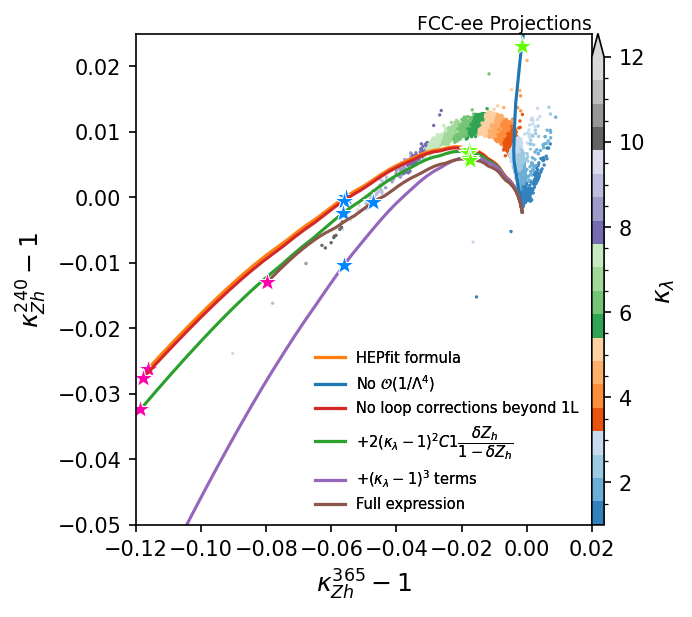

In [41]:
legend_locs = [
    None,
    None,
    None,
    None,
    None,
    "lower right",
    # 'upper left',
]
legend_fontsizes = [
    7.0,
    7.0,
    7.0,
    7.0,
    7.0,
    7.0,
]
fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections",
                        data_with_WFR=True,
                        data_with_WFR_no_BSM_vertex=False,
                )
plot_curve_CH_CHbox(
    ax,
    curves_uncertainty_estimation, 
    k_ZH_240_365_predictions_file_names_all_WCs, 
    data_sets, 
    legend_locs, 
    legend_cols, 
    markers, 
    color_lines, 
    label_lines, 
    markersizes,
    with_markers=True,
    n_markers=3,
)
ax.set_xlim(-0.12, +0.02)
ax.set_ylim(-0.050, +0.025)
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"_comparison_uncertainty_estimation_all_WCs_markers_zoom.pdf")


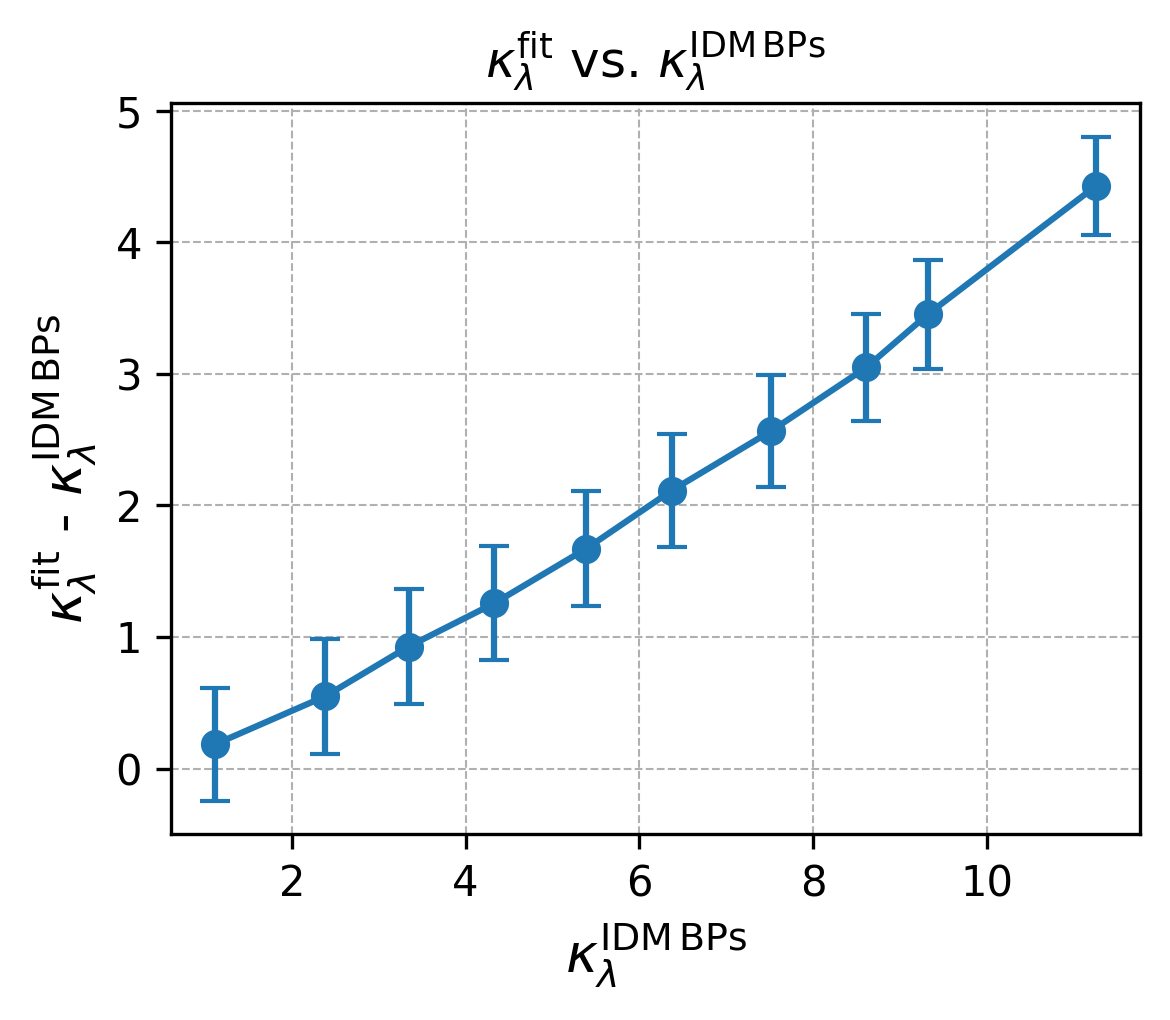

In [42]:
klam_BPs = np.array([BP["lam"] for BP in bp_kappas])
klam_BPs = klam_BPs[2::2]
# k_ZH_240_BPs = [BP["ZZ_240_with_WFR_ZZh1L_hextlegonly"] for BP in bp_kappas]
# k_ZH_365_BPs = [BP["ZZ_365_with_WFR_ZZh1L_hextlegonly"] for BP in bp_kappas]

klam_fits = []
klam_fits_errors = []
input_dir = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/IDM_fits/Fits_HLLHC_FCCee/different_BPs/comparison_plots/results_fits_realistic_HL_LHC_WFR_kala2_input_all_small_priors_long"
with open(f"{input_dir}/klam_results.txt", 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        if i == 0:  # Skip header line
            continue

        BP, klam, klam_error = line.split(",")
        klam_fits.append(float(klam))
        klam_fits_errors.append(float(klam_error))

klam_fits = np.array(klam_fits[::2])
klam_fits_errors = np.array(klam_fits_errors[::2])

spline_degree = 1  # Linear interpolation
klam_interpolator = make_interp_spline(klam_BPs, klam_fits, k=spline_degree)

# klam_curve = np.linspace(-32, 0, 50)

delta_klam = klam_fits - klam_BPs
color = "tab:blue"
plt.subplots(figsize=(4.0, 3.5), dpi=300)
plt.plot(klam_BPs, delta_klam, color=color)
plt.errorbar(klam_BPs, delta_klam, yerr=klam_fits_errors, fmt='o', capsize=3.5, color=color)
    
plt.xlabel(r"$\kappa_\lambda^{\mathrm{IDM\/BPs}}$", fontsize=13)
plt.ylabel(r"$\kappa_\lambda^{\mathrm{fit}}$ - $\kappa_\lambda^{\mathrm{IDM\/BPs}}$", fontsize=13)
plt.title(r"$\kappa_\lambda^{\mathrm{fit}}$ vs. $\kappa_\lambda^{\mathrm{IDM\/BPs}}$")
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(f'{plot_dir}/{plot_name}'+"k_ZH_240_365_uncertainties_klam_fit_vs_IDM.pdf")

Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']


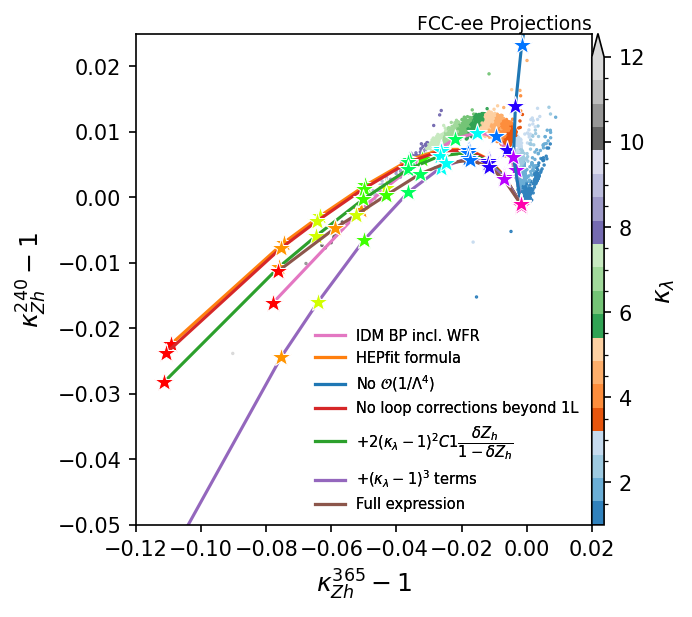

In [43]:
results_directory = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/IDM_fits/Uncertainty_estimation/all_WCs/comparison_plots"
flags = ["", "_noLoopH3d6Quad", "_LoopHd6NoSubleading", "_LoopH3d6Quad_C1term", "_LoopH3d6Cubi", "_LoopH3d6Full"]
for flag in flags:
    with open(f"{results_directory}/k_ZH_240_365_predictions_BPs_{flag}.txt", 'r') as input_file:
        with open(f"{results_directory}/k_ZH_240_365_predictions_BPs_{flag}_even.txt", 'w') as output_file:
            lines = input_file.readlines()
            for idx, line in enumerate(lines):
                if idx % 4 == 0 or idx % 4 == 1:
                    output_file.write(line)


k_ZH_240_365_predictions_file_names_all_WCs = [
    None,
    f"{results_directory}/k_ZH_240_365_predictions_BPs__even.txt",
    f"{results_directory}/k_ZH_240_365_predictions_BPs__noLoopH3d6Quad_even.txt",
    f"{results_directory}/k_ZH_240_365_predictions_BPs__LoopHd6NoSubleading_even.txt",
    f"{results_directory}/k_ZH_240_365_predictions_BPs__LoopH3d6Quad_C1term_even.txt",
    f"{results_directory}/k_ZH_240_365_predictions_BPs__LoopH3d6Cubi_even.txt",
    f"{results_directory}/k_ZH_240_365_predictions_BPs__LoopH3d6Full_even.txt",
]

plot_points_with_WFR = [
    (BP["ZZ_365_with_WFR"] - 1,
     BP["ZZ_240_with_WFR"] - 1,
     BP["lam"],
     label, ) for BP, label in zip(bp_kappas, BP_Names_legend)
]
plot_points_with_WFR = plot_points_with_WFR[2::2]

legend_locs = [
    None,
    None,
    None,
    None,
    None,
    None,
    "lower right",
    # 'upper left',
]
legend_fontsizes = [
    7.0,
    7.0,
    7.0,
    7.0,
    7.0,
    7.0,
    7.0,
]
markers = [
    "*", 
    "*", 
    "*", 
    "*", 
    "*", 
    "*", 
    "*", 
]
markersizes = [
    10, 
    10, 
    10, 
    10, 
    10, 
    10, 
    10, 
]
color_lines = [
    "tab:pink",
    "tab:orange",
    "tab:blue",
    "tab:red",
    "tab:green",
    "tab:purple",
    "tab:brown",
]
label_lines = [
    r'IDM BP incl. WFR',
    r'HEPfit formula',
    r'No $\mathcal{O}(1/\Lambda^4)$',
    r'No loop corrections beyond 1L',
    r'$+ 2(\kappa_{\lambda}-1)^2 C1 \dfrac{\delta Z_h}{1-\delta Z_h}$',
    r'$+(\kappa_{\lambda}-1)^3$ terms',
    r'Full expression',
]
legend_cols = [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
]
curves_uncertainty_estimation = [
    "IDM",
    "HEPfit", 
    "noLoopH3d6Quad",
    "LoopHd6NoSubleading",
    "LoopH3d6Quad_C1term",
    "LoopH3d6Cubi",
    "LoopH3d6Full",
]
data_sets = [
    plot_points_with_WFR,
    None,
    None,
    None,
    None,
    None,
    None,
]



fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections",
                        data_with_WFR=True,
                        data_with_WFR_no_BSM_vertex=False,
                )
plot_curve_CH_CHbox(
    ax,
    curves_uncertainty_estimation, 
    k_ZH_240_365_predictions_file_names_all_WCs, 
    data_sets, 
    legend_locs, 
    legend_cols, 
    markers, 
    color_lines, 
    label_lines, 
    markersizes,
    with_markers=True,
    n_markers=10,
)
ax.set_xlim(-0.12, +0.02)
ax.set_ylim(-0.050, +0.025)
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"_uncertainty_all_WCs_with_IDM_WFR_BPs_zoom.pdf")


Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']


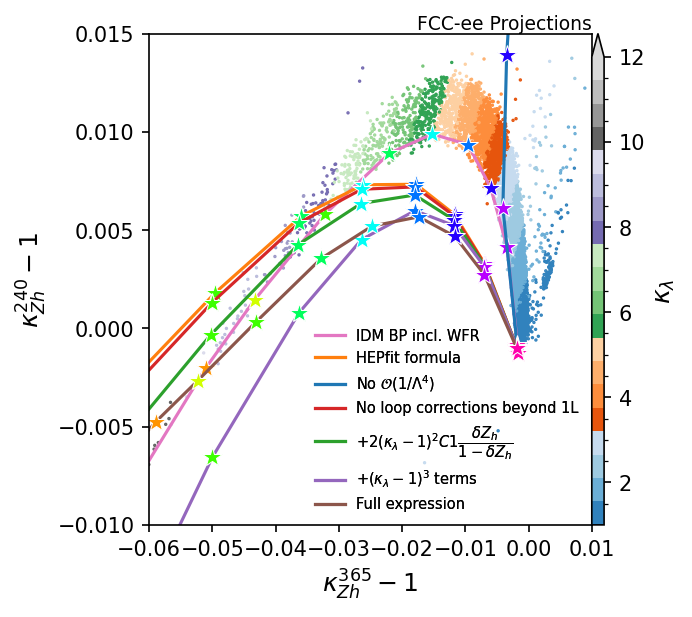

In [44]:
legend_locs = [
    None,
    None,
    None,
    None,
    None,
    None,
    "lower right",
    # 'upper left',
]
fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir,
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        # plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True,
                        upper_right_text="FCC-ee Projections",
                        data_with_WFR=True,
                        data_with_WFR_no_BSM_vertex=False,
                )
plot_curve_CH_CHbox(
    ax,
    curves_uncertainty_estimation, 
    k_ZH_240_365_predictions_file_names_all_WCs, 
    data_sets, 
    legend_locs, 
    legend_cols, 
    markers, 
    color_lines, 
    label_lines, 
    markersizes,
    with_markers=True,
    n_markers=10,
)
ax.set_xlim(-0.06, +0.01)
ax.set_ylim(-0.010, +0.015)
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"_uncertainty_all_WCs_with_IDM_WFR_BPs_zoom2.pdf")

Processing file: /cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/IDM_fits/Uncertainty_estimation/all_WCs/comparison_plots/k_ZH_240_365_predictions_BPs__even.txt
[0.9990554595048612, 1.0032882084333903, 1.0057934192133393, 1.0073297694563659, 1.0073045106360168, 1.0057118064899806, 1.0018205093246724, 0.9971125167833784, 0.9930381690598447, 0.9775456204878801]
Processing file: /cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/IDM_fits/Uncertainty_estimation/all_WCs/comparison_plots/k_ZH_240_365_predictions_BPs__noLoopH3d6Quad_even.txt
[0.9991270679307822, 1.0061392522007802, 1.013891481867508, 1.0231766600502017, 1.0348053419477665, 1.0473685043589105, 1.0628417365640555, 1.080663542671499, 1.0944510574066586, 1.133515893777663]
Processing file: /cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/IDM_fits/Uncertainty_estimation/all_WCs/comparison_plots/k_ZH_240_365_predictions_BPs__LoopHd6NoSubleading_even.txt
[0.9990541812335461, 1.0032615651237649, 1.005722849852799, 1.007195480366

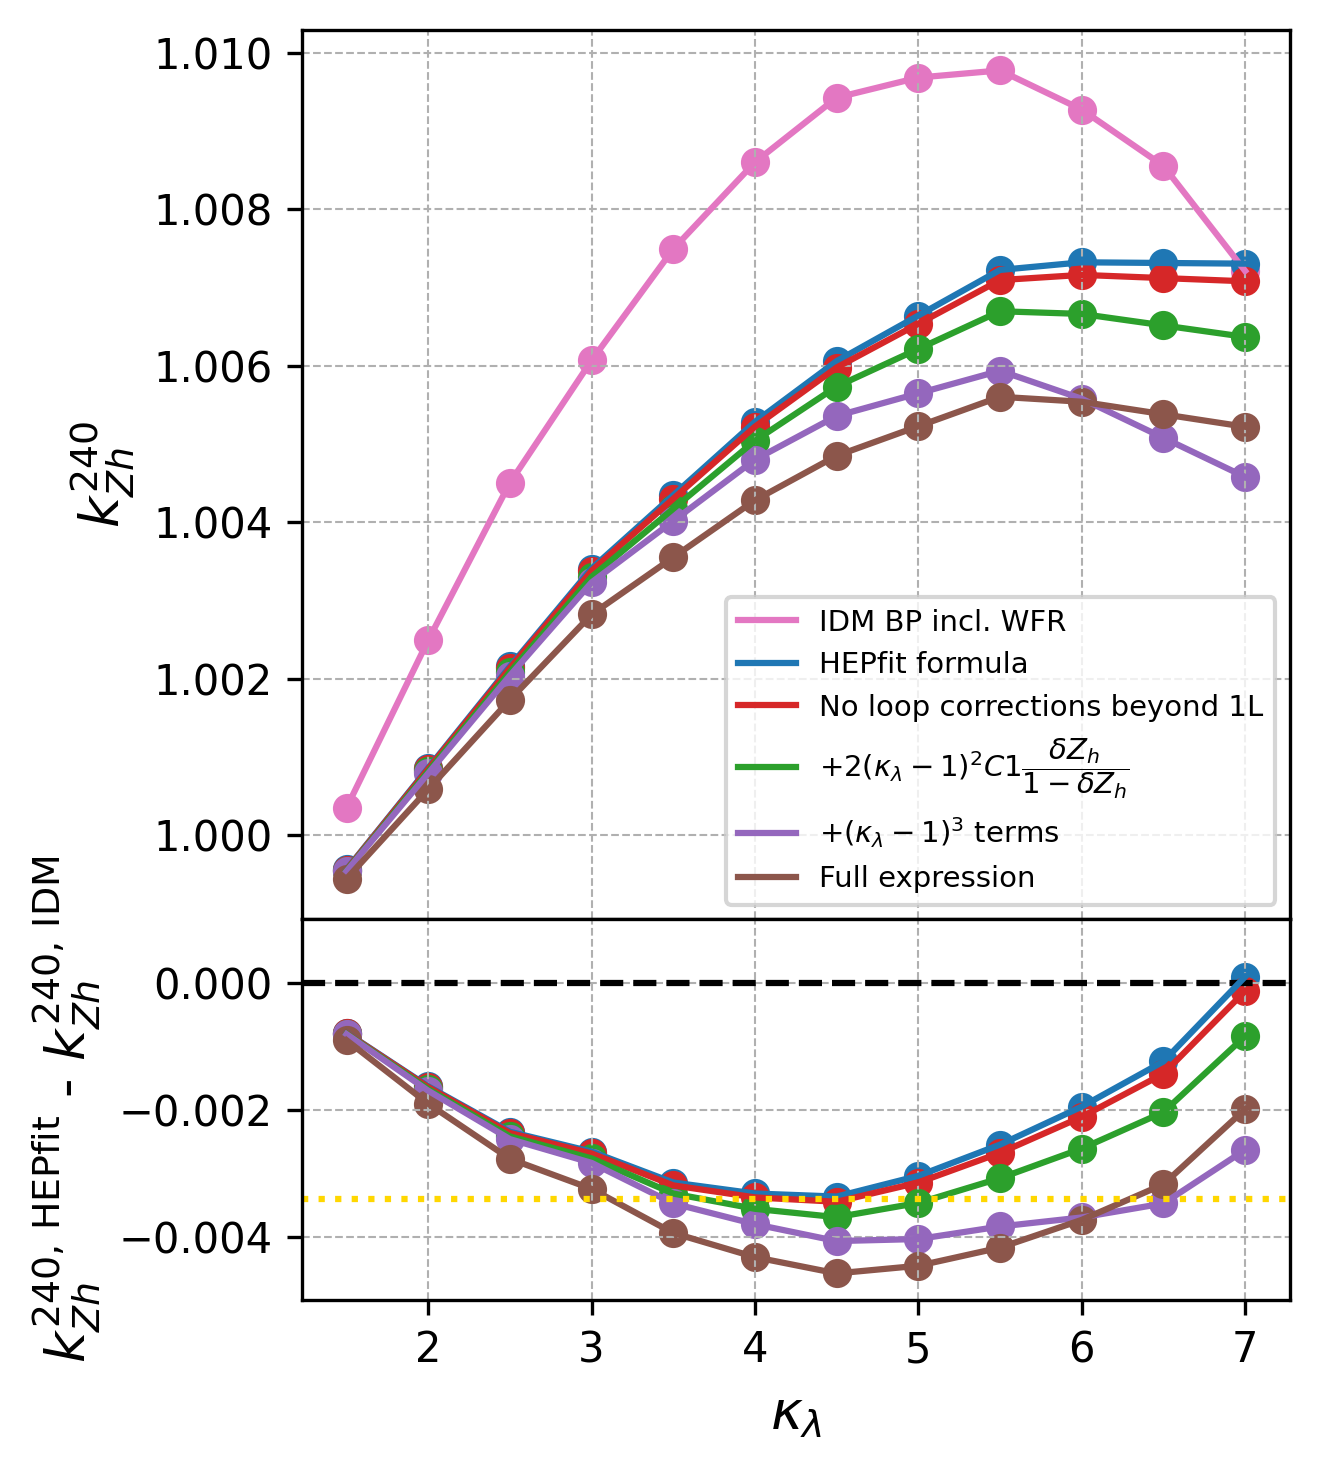

In [45]:
spline_degree = 1  # Linear interpolation
interpolators = {}
# klam_points = np.array([1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0])
klam_points = np.linspace(1.5, 7.0, 12)

interpolations = {}
for flag in flags:
    interpolators[flag] = {}
    interpolations[flag] = {}
    file_name = f"{results_directory}/k_ZH_240_365_predictions_BPs_{flag}_even.txt"
    print(f"Processing file: {file_name}")
    k_ZH_240_values = []
    k_ZH_365_values = []
    with open(file_name, "r") as self_consistent_results_file:
        lines = self_consistent_results_file.readlines()
        for n, line in enumerate(lines):
            columns = line.split()

            if columns[-2].startswith("eeZH_FCCee240"):
                k_ZH_240_values.append(np.sqrt(float(columns[-1])))
            elif columns[-2].startswith("eeZH_FCCee365"):
                k_ZH_365_values.append(np.sqrt(float(columns[-1])))
        print(k_ZH_240_values)
    interpolators[flag]["k_ZH_240"] = make_interp_spline(klam_fits, k_ZH_240_values, k=spline_degree)
    interpolators[flag]["k_ZH_365"] = make_interp_spline(klam_fits, k_ZH_365_values, k=spline_degree)

    interpolations[flag]["k_ZH_240"] = interpolators[flag]["k_ZH_240"](klam_points)
    interpolations[flag]["k_ZH_365"] = interpolators[flag]["k_ZH_365"](klam_points)

k_ZH_240_BPs = [BP["ZZ_240_with_WFR"] for BP in bp_kappas]
k_ZH_365_BPs = [BP["ZZ_365_with_WFR"] for BP in bp_kappas]
k_ZH_240_BPs = np.array(k_ZH_240_BPs[2::2])
k_ZH_365_BPs = np.array(k_ZH_365_BPs[2::2])
IDM_interpolator_k_ZH_240 = make_interp_spline(klam_BPs, k_ZH_240_BPs, k=spline_degree)
IDM_interpolator_k_ZH_365 = make_interp_spline(klam_BPs, k_ZH_365_BPs, k=spline_degree)
IDM_interpolation_k_ZH_240 = IDM_interpolator_k_ZH_240(klam_points)
IDM_interpolation_k_ZH_365 = IDM_interpolator_k_ZH_365(klam_points)

# fig, ax = plt.subplots(figsize=(4.0, 3.5), dpi=300)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(4.5, 5), height_ratios=[0.7, 0.3], dpi=300, gridspec_kw=dict(hspace=0.))

flag_colors = ["tab:blue", "tab:orange", "tab:red", "tab:green", "tab:purple", "tab:brown"]
flag_labels = [
    # r'IDM BP incl. WFR',
    r'HEPfit formula',
    r'No $\mathcal{O}(1/\Lambda^4)$',
    r'No loop corrections beyond 1L',
    r'$+ 2(\kappa_{\lambda}-1)^2 C1 \dfrac{\delta Z_h}{1-\delta Z_h}$',
    r'$+(\kappa_{\lambda}-1)^3$ terms',
    r'Full expression',
]
ax2.axhline(0, color='black', linestyle='--', linewidth=1.5)
ax1.plot(klam_points, IDM_interpolation_k_ZH_240, label=r'IDM BP incl. WFR', color="tab:pink")
ax1.scatter(klam_points, IDM_interpolation_k_ZH_240, color="tab:pink")
for idx, (flag, color, label) in enumerate(zip(flags, flag_colors, flag_labels)):
    if flag == "_noLoopH3d6Quad":
        continue
    ax1.plot(klam_points, interpolations[flag]["k_ZH_240"], label=label, color=color)
    ax1.scatter(klam_points, interpolations[flag]["k_ZH_240"], color=color)

    ax2.plot(klam_points, interpolations[flag]["k_ZH_240"] - IDM_interpolation_k_ZH_240, label=label, color=color)
    ax2.scatter(klam_points, interpolations[flag]["k_ZH_240"] - IDM_interpolation_k_ZH_240, color=color)
    # plt.plot(klam_points, interpolations[flag]["k_ZH_365"], label=f"k_ZH_365 {flag}", color="tab:orange")

ax2.set_xlabel(r"$\kappa_\lambda$", fontsize=13)
ax1.set_ylabel(r"$k_{Zh}^{240}$", fontsize=13)
ax2.set_ylabel(r"$k_{Zh}^{240,\/\mathrm{HEPfit}}$ - $k_{Zh}^{240,\/\mathrm{IDM}}$", fontsize=13)
# plt.title(r"$k_{Zh}^{240}$ vs. $\kappa_\lambda$ for different flags")
ax1.grid(which='both', linestyle='--', linewidth=0.5)
ax2.grid(which='both', linestyle='--', linewidth=0.5)
ax1.legend(fontsize=7.0, loc='lower right')
ax2.set_ylim(-0.005, 0.001)

# Obtaining uncertainty estimate:
err_estimate = []
for idx, klam in enumerate(klam_points[:-2]):
    flags_for_error = [flag for flag in flags if flag != "_noLoopH3d6Quad" ]
    diffs = [interpolations[flag]["k_ZH_240"][idx] - IDM_interpolation_k_ZH_240[idx] for flag in flags_for_error]
    err_estimate.append( np.max( np.abs(diffs) ) )
print(f"Maximum errors: {err_estimate}")
k_Zh_240_err = np.mean(err_estimate)
print(f"k_Zh_240 uncertainty estimate: {k_Zh_240_err}")
print(f"sigma_Zh_240 uncertainty estimate: {2 * (np.mean(IDM_interpolation_k_ZH_240)) * k_Zh_240_err}")
ax2.axhline(-k_Zh_240_err, color='gold', linestyle=':', linewidth=1.5)

plt.tight_layout()
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"_k_ZH_240_vs_kappa_lambda_all_WCs.pdf")


Maximum errors: [0.000334002745037143, 0.0011927408238858739, 0.001905300290698575, 0.0021423301483479706, 0.0024603081046734587, 0.002474093435301694, 0.002432594834000601, 0.002085621167978946, 0.0015745402253083407, 0.0009166531117026366]
k_Zh_365 uncertainty estimate: 0.001751818488693524
sigma_Zh_365 uncertainty estimate: 0.0034632124670086065


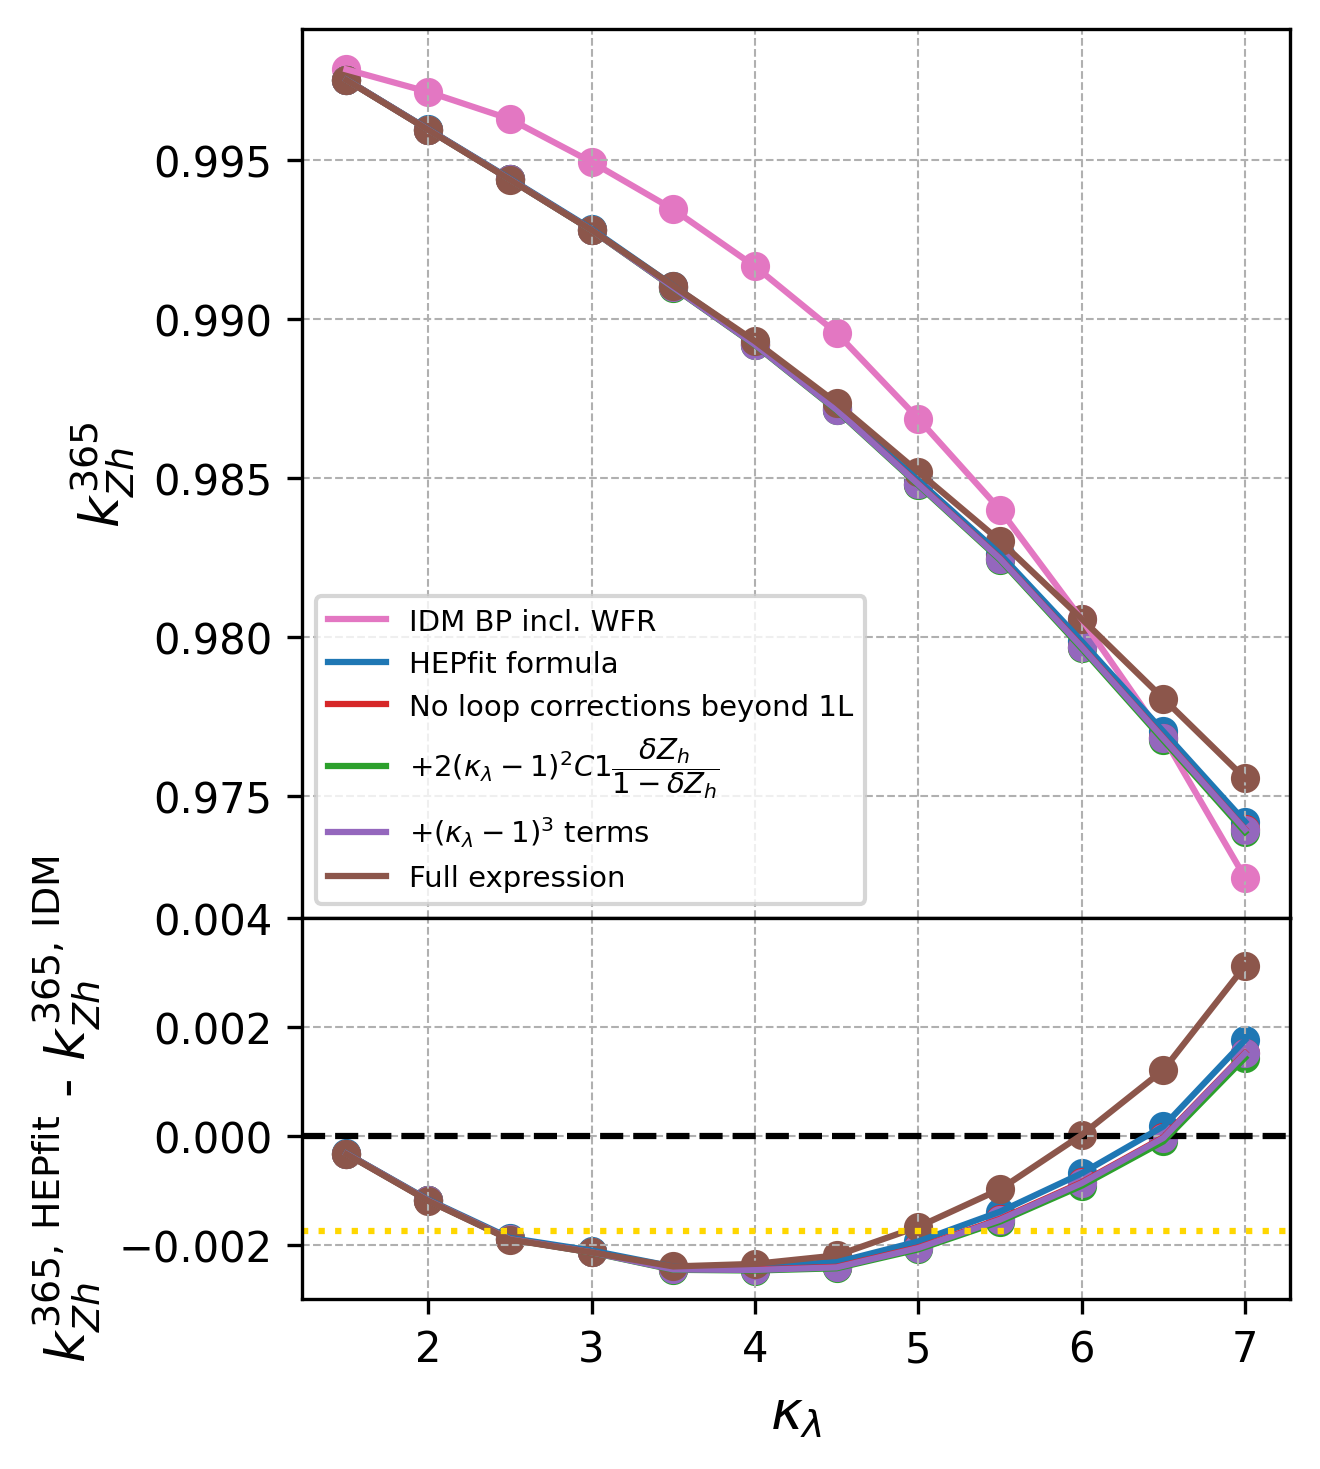

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(4.5, 5), height_ratios=[0.7, 0.3], dpi=300, gridspec_kw=dict(hspace=0.))

ax2.axhline(0, color='black', linestyle='--', linewidth=1.5)
ax1.plot(klam_points, IDM_interpolation_k_ZH_365, label=r'IDM BP incl. WFR', color="tab:pink")
ax1.scatter(klam_points, IDM_interpolation_k_ZH_365, color="tab:pink")
for idx, (flag, color, label) in enumerate(zip(flags, flag_colors, flag_labels)):
    if flag == "_noLoopH3d6Quad":
        continue
    ax1.plot(klam_points, interpolations[flag]["k_ZH_365"], label=label, color=color)
    ax1.scatter(klam_points, interpolations[flag]["k_ZH_365"], color=color)

    ax2.plot(klam_points, interpolations[flag]["k_ZH_365"] - IDM_interpolation_k_ZH_365, label=label, color=color)
    ax2.scatter(klam_points, interpolations[flag]["k_ZH_365"] - IDM_interpolation_k_ZH_365, color=color)
    # plt.plot(klam_points, interpolations[flag]["k_ZH_365"], label=f"k_ZH_365 {flag}", color="tab:orange")

ax2.set_xlabel(r"$\kappa_\lambda$", fontsize=13)
ax1.set_ylabel(r"$k_{Zh}^{365}$", fontsize=13)
ax2.set_ylabel(r"$k_{Zh}^{365,\/\mathrm{HEPfit}}$ - $k_{Zh}^{365,\/\mathrm{IDM}}$", fontsize=13)
# plt.title(r"$k_{Zh}^{365}$ vs. $\kappa_\lambda$ for different flags")
ax1.grid(which='both', linestyle='--', linewidth=0.5)
ax2.grid(which='both', linestyle='--', linewidth=0.5)
ax1.legend(fontsize=7.0, loc='lower left')
ax2.set_ylim(-0.003, 0.004)

# Obtaining uncertainty estimate:
err_estimate = []
for idx, klam in enumerate(klam_points[:-2]):
    flags_for_error = [flag for flag in flags if flag != "_noLoopH3d6Quad" ]
    diffs = [interpolations[flag]["k_ZH_365"][idx] - IDM_interpolation_k_ZH_365[idx] for flag in flags_for_error]
    err_estimate.append( np.max( np.abs(diffs) ) )
print(f"Maximum errors: {err_estimate}")
k_Zh_365_err = np.mean(err_estimate)
print(f"k_Zh_365 uncertainty estimate: {k_Zh_365_err}")
print(f"sigma_Zh_365 uncertainty estimate: {2 * (np.mean(IDM_interpolation_k_ZH_365)) * k_Zh_365_err}")
ax2.axhline(-k_Zh_365_err, color='gold', linestyle=':', linewidth=1.5)

plt.tight_layout()
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+"_k_ZH_365_vs_kappa_lambda_all_WCs.pdf")


## Final plot for the 2-page document

[{'uu': 0.991329519562304, 'dd': 0.991329519562304, 'ss': 0.991329519562304, 'cc': 0.991329519562304, 'bb': 0.991329519562304, 'tt': 0.991329519562304, 'ee': 0.991329519562304, 'mumu': 0.991329519562304, 'tautau': 0.991329519562304, 'ZZ_0': 1.000248738282997, 'ZZ_240': 1.0077713199799205, 'ZZ_365': 1.0002131692051668, 'ZZ_500': 0.997795877018984, 'ZZ_550': 0.9973832902199067, 'ZZ': 0.9920448239572286, 'WW': 0.9920448239572286, 'lam': 2.3867362274064843, 'gamgam': 0.974955131015653, 'Zgam': 0.9907251332792432, 'ZZ_0_with_WFR': 0.9966292246707532, 'ZZ_240_with_WFR': 1.0041488808247878, 'ZZ_365_with_WFR': 0.996593534653003, 'ZZ_500_with_WFR': 0.9941650209798174, 'ZZ_550_with_WFR': 0.9937499259580582, 'ZZ_0_with_WFR_no_BSM': 1.0020424230905143, 'ZZ_240_with_WFR_no_BSM': 1.0090590603477374, 'ZZ_365_with_WFR_no_BSM': 1.0009188574744274, 'ZZ_500_with_WFR_no_BSM': 0.9975151185370316, 'ZZ_550_with_WFR_no_BSM': 0.9966484440745323, 'ZZ_0_with_WFR_ZZh1L_hextlegonly': 0.9933519299813723, 'ZZ_240_wi

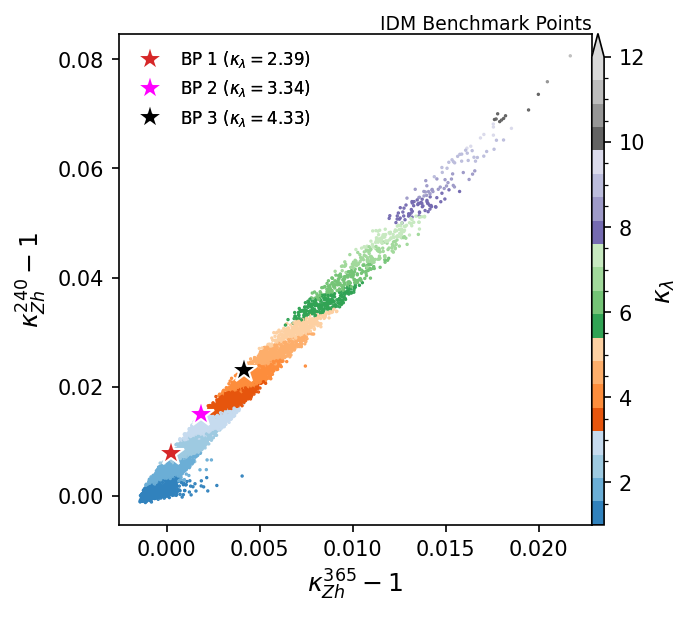

In [73]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
BR_constraints = 0.05
BPs_plot_final = ["BPB_2", "BPB_4", "BPB_6", ]


BP_Names_legend_plot_final = [rf"BP {i+1} ($\kappa_\lambda=${bp_kappas[BP_Names.index(BP)]['lam']:.3g})"  for i, BP in enumerate(BPs_plot_final)]
bp_kappas_plot_final = [bp_kappas[BP_Names.index(BP)] for BP in BPs_plot_final]
print(bp_kappas_plot_final)
plot_points = [(BP["ZZ_365"]-1, BP["ZZ_240"]-1, label, BP["lam"]) for BP, label in zip(bp_kappas_plot_final, BP_Names_legend_plot_final)]

plot_EffZZH_240_vs_365(data_file, plot_dir,
                       BR_constraints=BR_constraints,
                       plot_points=plot_points,
                      #  point_colors="lambdas",
                       point_colors=["tab:red", "fuchsia", "k"],
                       point_leg_columns=1,
                       point_leg_size=8,
                      #  point_marker_size=[13, 10, 10],
                       point_marker_size=[13, 13, 13],
                      #  point_markers=["*", "o", "^"],
                       point_markers=["*", "*", "*"],
                       no_model_text=True,
                       upper_right_text="IDM Benchmark Points",
                    #    plot_name_suffix="_final_2pager",
                       markeredgewidth=[1, 1, 1],
                )
plot_name= f"IDM_BPs_240_vs_365_{BR_constraints:0.3g}_SM_constraints_BPs_final"
plot_name_suffix=""
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+".pdf")

[{'uu': 0.991329519562304, 'dd': 0.991329519562304, 'ss': 0.991329519562304, 'cc': 0.991329519562304, 'bb': 0.991329519562304, 'tt': 0.991329519562304, 'ee': 0.991329519562304, 'mumu': 0.991329519562304, 'tautau': 0.991329519562304, 'ZZ_0': 1.000248738282997, 'ZZ_240': 1.0077713199799205, 'ZZ_365': 1.0002131692051668, 'ZZ_500': 0.997795877018984, 'ZZ_550': 0.9973832902199067, 'ZZ': 0.9920448239572286, 'WW': 0.9920448239572286, 'lam': 2.3867362274064843, 'gamgam': 0.974955131015653, 'Zgam': 0.9907251332792432, 'ZZ_0_with_WFR': 0.9966292246707532, 'ZZ_240_with_WFR': 1.0041488808247878, 'ZZ_365_with_WFR': 0.996593534653003, 'ZZ_500_with_WFR': 0.9941650209798174, 'ZZ_550_with_WFR': 0.9937499259580582, 'ZZ_0_with_WFR_no_BSM': 1.0020424230905143, 'ZZ_240_with_WFR_no_BSM': 1.0090590603477374, 'ZZ_365_with_WFR_no_BSM': 1.0009188574744274, 'ZZ_500_with_WFR_no_BSM': 0.9975151185370316, 'ZZ_550_with_WFR_no_BSM': 0.9966484440745323, 'ZZ_0_with_WFR_ZZh1L_hextlegonly': 0.9933519299813723, 'ZZ_240_wi

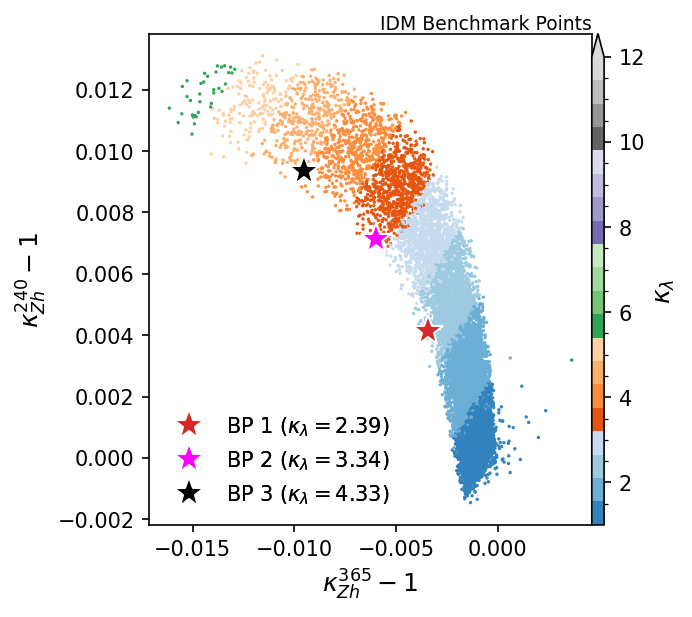

In [74]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
BR_constraints = 0.05
BPs_plot_final = ["BPB_2", "BPB_4", "BPB_6", ]


BP_Names_legend_plot_final = [rf"BP {i+1} ($\kappa_\lambda=${bp_kappas[BP_Names.index(BP)]['lam']:.3g})"  for i, BP in enumerate(BPs_plot_final)]
bp_kappas_plot_final = [bp_kappas[BP_Names.index(BP)] for BP in BPs_plot_final]
print(bp_kappas_plot_final)
plot_points_with_WFR = [
    (BP["ZZ_365_with_WFR"] - 1,
     BP["ZZ_240_with_WFR"] - 1,
     label, 
     BP["lam"], ) for BP, label in zip(bp_kappas_plot_final, BP_Names_legend_plot_final)
]

plot_EffZZH_240_vs_365(data_file, plot_dir,
                       BR_constraints=BR_constraints,
                       plot_points=plot_points_with_WFR,
                      #  point_colors="lambdas",
                       point_colors=["tab:red", "fuchsia", "k"],
                       point_leg_columns=1,
                       point_leg_size=10,
                       legend_loc="lower left",
                      #  point_marker_size=[13, 10, 10],
                       point_marker_size=[15, 15, 15],
                      #  point_markers=["*", "o", "^"],
                       point_markers=["*", "*", "*"],
                       no_model_text=True,
                       upper_right_text="IDM Benchmark Points",
                    #    plot_name_suffix="_final_2pager",
                       markeredgewidth=[1, 1, 1],
                       data_with_WFR=True,
                       data_with_WFR_no_BSM_vertex=False,
                       data_with_WFR_ZZh1L_hextlegonly=False
                )
plot_name= f"IDM_BPs_240_vs_365_{BR_constraints:0.3g}_SM_constraints_BPs_final"
plot_name_suffix="_with_WFR"
plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+".pdf")